# Mlb Player_info

## imports 

In [37]:
import pandas as pd
import numpy as np
import sqlite3
import joblib
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 
from xgboost import plot_importance
import sys
import os

# For Jupyter notebooks, use the current working directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

import config

print("DB_PATH:", config.DB_PATH)
print("INJURY_MODEL_PATH:", config.INJURY_MODEL_PATH)

db_path = config.DB_PATH
model_path = config.INJURY_MODEL_PATH

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

pd.set_option('display.max_columns', None)

DB_PATH: /Users/daniellarson/Desktop/Code/Projects/dodgers_injtrkr/mlb/mlb_players.db
INJURY_MODEL_PATH: /Users/daniellarson/Desktop/Code/Projects/dodgers_injtrkr/mlb/models/injury_risk_model.pkl


In [16]:

#conn = sqlite3.connect(db_path)
#cursor = conn.cursor()

# Set up your DB path
#base_dir = '/Users/daniellarson/Desktop/Code/Projects/dodgers_injtrkr'
#db_path = os.path.join(base_dir, 'data', 'mlb_players.db')  
#pd.set_option('display.max_columns', None)

In [17]:
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn) 
print(tables) 

               name
0   mlb_player_info
1   sqlite_sequence
2      injury_stats
3  mlb_player_stats


## MLB Player info 

In [9]:
mlb_player_info = pd.read_sql_query("SELECT * FROM mlb_player_info", conn)

mlb_player_info.head()


,id,mlb_player_id,fullName,firstName,lastName,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,height,weight,primaryPosition,batSide,pitchHand,debutDate,active
0,1,671096,Andrew Abbott,Andrew,Abbott,1999-06-01,25,Lynchburg,VA,USA,"6' 0""",192,Pitcher,Left,Left,2023-06-05,1
1,2,682928,CJ Abrams,Paul,Abrams,2000-10-03,24,Alpharetta,GA,USA,"6' 0""",191,Shortstop,Left,Right,2022-04-08,1
2,3,650556,Bryan Abreu,Bryan,Abreu,1997-04-22,28,Santo Domingo Centro,None,Dominican Republic,"6' 1""",230,Pitcher,Right,Right,2019-07-31,1
3,4,677800,Wilyer Abreu,Wilyer,Abreu,1999-06-24,25,Maracaibo,None,Venezuela,"5' 10""",215,Outfielder,Left,Left,2023-08-22,1
4,5,682668,Luisangel Acuña,Luisangel,Acuña,2002-03-12,23,Caracas,None,Venezuela,"5' 8""",181,Second Base,Right,Right,2024-09-14,1


In [ ]:

# Get the last 10 mlb_player_ids

query = """
SELECT mlb_player_id
FROM mlb_player_info
ORDER BY mlb_player_id DESC
LIMIT 10;
"""

pd.read_sql_query(query, conn)

,mlb_player_id
0,820862
1,810938
2,808982
3,808975
4,808967
5,808963
6,807713
7,807712
8,806188
9,806185


## MLB Player stats 

In [72]:
mlb_player_stats = pd.read_sql_query("SELECT * FROM mlb_player_stats", conn)

mlb_player_stats

,mlb_player_id,stat_type,stat_group,season,game_date,team_id,team_name,opponent_id,opponent_name,position,gamesPlayed,games,gamesStarted,assists,putOuts,errors,chances,fielding,doublePlays,triplePlays,throwingErrors,rangeFactorPerGame,rangeFactorPer9Inn,innings,inningsPitched,catcherERA,flyOuts,groundOuts,airOuts,passedBall,wins,losses,wildPitches,pickoffs,runs,doubles,triples,homeRuns,strikeOuts,baseOnBalls,intentionalWalks,hits,hitByPitch,avg,atBats,obp,slg,ops,caughtStealing,stolenBases,stolenBasePercentage,groundIntoDoublePlay,groundIntoTriplePlay,numberOfPitches,plateAppearances,totalBases,rbi,leftOnBase,sacBunts,sacFlies,babip,groundOutsToAirouts,catchersInterference,atBatsPerHomeRun,summary,isHome,isWin,game_id,game_number,day_night,era,game
0,445276,season,fielding,2024,None,111.0,Boston Red Sox,NaN,None,NA,54,54,0.0,1.0,1.0,0.0,2.0,1.000,0.0,0.0,0.0,0.04,0.33,54.2,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN,NaN,NaN,NaN,None,na,na
1,445276,season,hitting,2024,None,111.0,Boston Red Sox,NaN,None,None,54,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,NaN,0.0,0.0,NaN,None,None,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.000,0.0,.000,.000,.000,0.0,0.0,.---,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.---,-.--,0.0,-.--,None,NaN,NaN,NaN,NaN,None,na,na
2,455117,season,fielding,2024,None,145.0,Chicago White Sox,NaN,None,NA,48,48,46.0,11.0,378.0,2.0,391.0,.995,0.0,0.0,1.0,8.10,9.02,388.2,None,4.61,NaN,NaN,NaN,3.0,None,None,18.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,3.0,39.0,.929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,1.0,None,None,NaN,NaN,NaN,NaN,None,na,na
3,455117,season,hitting,2024,None,145.0,Chicago White Sox,NaN,None,None,48,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,NaN,30.0,41.0,NaN,None,None,NaN,NaN,9.0,3.0,0.0,4.0,51.0,8.0,0.0,16.0,1.0,.119,135.0,.174,.230,.404,0.0,0.0,.---,5.0,NaN,556.0,147.0,31.0,11.0,56.0,3.0,0.0,.150,0.73,0.0,33.75,None,NaN,NaN,NaN,NaN,None,na,na
4,455117,career,fielding,None,None,NaN,None,NaN,None,NA,1132,1132,1053.0,513.0,9044.0,63.0,9620.0,.993,47.0,0.0,51.0,8.44,9.32,9227.1,None,3.81,NaN,NaN,NaN,78.0,None,None,367.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,184.0,444.0,.707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,16.0,None,None,NaN,NaN,NaN,NaN,None,na,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436883,810938,gameLog,fielding,2025,2025-05-13,136.0,Seattle Mariners,147.0,New York Yankees,NA,1,1,1.0,3.0,0.0,0.0,3.0,.964,0.0,0.0,0.0,3.00,2.45,11.0,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,1.0,1.0,777926.0,1.0,day,na,na
436884,810938,gameLog,fielding,2025,2025-05-14,136.0,Seattle Mariners,147.0,New York Yankees,NA,1,1,1.0,2.0,1.0,0.0,3.0,.966,0.0,0.0,0.0,3.00,3.00,9.0,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,1.0,0.0,777915.0,1.0,day,na,na
436885,810938,gameLog,fielding,2025,2025-05-16,136.0,Seattle Mariners,135.0,San Diego Padres,NA,1,1,1.0,2.0,0.0,0.0,2.0,.967,0.0,0.0,0.0,2.00,2.00,9.0,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,1.0,777896.0,1.0,day,na,na
436886,810938,gameLog,fielding,2025,2025-05-17,136.0,Seattle Mariners,135.0,San Diego Padres,NA,1,1,1.0,1.0,0.0,0.0,1.0,.968,0.0,0.0,0.0,1.00,1.00,9.0,None,None,NaN,NaN,NaN

In [71]:
mlb_player_stats.columns

Index(['mlb_player_id', 'stat_type', 'stat_group', 'season', 'game_date',
       'team_id', 'team_name', 'opponent_id', 'opponent_name', 'position',
       'gamesPlayed', 'games', 'gamesStarted', 'assists', 'putOuts', 'errors',
       'chances', 'fielding', 'doublePlays', 'triplePlays', 'throwingErrors',
       'rangeFactorPerGame', 'rangeFactorPer9Inn', 'innings', 'inningsPitched',
       'catcherERA', 'flyOuts', 'groundOuts', 'airOuts', 'passedBall', 'wins',
       'losses', 'wildPitches', 'pickoffs', 'runs', 'doubles', 'triples',
       'homeRuns', 'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits',
       'hitByPitch', 'avg', 'atBats', 'obp', 'slg', 'ops', 'caughtStealing',
       'stolenBases', 'stolenBasePercentage', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'numberOfPitches', 'plateAppearances',
       'totalBases', 'rbi', 'leftOnBase', 'sacBunts', 'sacFlies', 'babip',
       'groundOutsToAirouts', 'catchersInterference', 'atBatsPerHomeRun',
       'summary', '

In [ ]:
# Ecample csv of mlb_player_stats

mlb_player_stats_example = mlb_player_stats.head(100)

#mlb_player_stats_example.to_csv('mlb_player_stats_example.csv', index=False)

## Player info and stats

In [29]:
query = """
SELECT mlb_player_stats.* , mlb_player_info.*
FROM mlb_player_stats
JOIN mlb_player_info ON mlb_player_stats.mlb_player_id = mlb_player_info.mlb_player_id
"""
player_pre = pd.read_sql_query(query, conn)

# Reorder columns: fullName and mlb_player_id first, then the rest
cols = ['fullName', 'mlb_player_id'] + [col for col in player_pre.columns if col not in ['fullName', 'mlb_player_id']]
player_pre = player_pre[cols]

# Rename columns to make them more readable
player_df = player_pre.rename(columns={
    'fullName': 'Name',
    'mlb_player_id': 'PlayerID',
    'stat_type': 'StatType',
    'stat_group': 'StatGroup',
    'season': 'Season',
    'game_date': 'GameDate',
    'team_id': 'TeamID',
    'team_name': 'Team',
    'opponent_id': 'OpponentID',
    'opponent_name': 'Opponent',
    'position': 'Position',
    'gamesPlayed': 'GamesPlayed',
    'games': 'Games',
    'gamesStarted': 'GamesStarted',
    'assists': 'Assists',
    'putOuts': 'PutOuts',
    'errors': 'Errors',
    'chances': 'Chances',
    'fielding': 'Fielding%',
    'doublePlays': 'DoublePlays',
    'triplePlays': 'TriplePlays',
    'throwingErrors': 'ThrowingErrors',
    'rangeFactorPerGame': 'RangeFactor/Game',
    'rangeFactorPer9Inn': 'RangeFactor/9Inn',
    'innings': 'Innings',
    'inningsPitched': 'InningsPitched',
    'catcherERA': 'CatcherERA',
    'flyOuts': 'FlyOuts',
    'groundOuts': 'GroundOuts',
    'airOuts': 'AirOuts',
    'passedBall': 'PassedBall',
    'wins': 'Wins',
    'losses': 'Losses',
    'wildPitches': 'WildPitches',
    'pickoffs': 'Pickoffs',
    'runs': 'Runs',
    'doubles': 'Doubles',
    'triples': 'Triples',
    'homeRuns': 'HomeRuns',
    'strikeOuts': 'Strikeouts',
    'baseOnBalls': 'Walks',
    'intentionalWalks': 'IntentionalWalks',
    'hits': 'Hits',
    'hitByPitch': 'HitByPitch',
    'avg': 'BattingAvg',
    'atBats': 'AtBats',
    'obp': 'OnBase%',
    'slg': 'Slugging%',
    'ops': 'OPS',
    'caughtStealing': 'CaughtStealing',
    'stolenBases': 'StolenBases',
    'stolenBasePercentage': 'Steal%',
    'groundIntoDoublePlay': 'GIDP',
    'groundIntoTriplePlay': 'GITP',
    'numberOfPitches': 'PitchesThrown',
    'plateAppearances': 'PlateAppearances',
    'totalBases': 'TotalBases',
    'rbi': 'RBIs',
    'leftOnBase': 'LOB',
    'sacBunts': 'SacBunts',
    'sacFlies': 'SacFlies',
    'babip': 'BABIP',
    'groundOutsToAirouts': 'GO/AO',
    'catchersInterference': 'CatchersInterference',
    'atBatsPerHomeRun': 'AB/HR',
    'summary': 'Summary',
    'isHome': 'HomeGame',
    'isWin': 'Win',
    'game_id': 'GameID',
    'game_number': 'GameNumber',
    'day_night': 'GameTime',
    'era': 'ERA',
    'game': 'Game',
    'id': 'RowID',
    'firstName': 'FirstName',
    'lastName': 'LastName',
    'birthDate': 'BirthDate',
    'currentAge': 'Age',
    'birthCity': 'BirthCity',
    'birthStateProvince': 'BirthState',
    'birthCountry': 'BirthCountry',
    'height': 'Height',
    'weight': 'Weight',
    'primaryPosition': 'PrimaryPosition',
    'batSide': 'BatSide',
    'pitchHand': 'PitchHand',
    'debutDate': 'DebutDate',
    'active': 'IsActive'
})

# Show the updated DataFrame
player_pre.columns

Index(['fullName', 'mlb_player_id', 'mlb_player_id', 'stat_type', 'stat_group',
       'season', 'game_date', 'team_id', 'team_name', 'opponent_id',
       'opponent_name', 'position', 'gamesPlayed', 'games', 'gamesStarted',
       'assists', 'putOuts', 'errors', 'chances', 'fielding', 'doublePlays',
       'triplePlays', 'throwingErrors', 'rangeFactorPerGame',
       'rangeFactorPer9Inn', 'innings', 'inningsPitched', 'catcherERA',
       'flyOuts', 'groundOuts', 'airOuts', 'passedBall', 'wins', 'losses',
       'wildPitches', 'pickoffs', 'runs', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'avg', 'atBats', 'obp', 'slg', 'ops', 'caughtStealing', 'stolenBases',
       'stolenBasePercentage', 'groundIntoDoublePlay', 'groundIntoTriplePlay',
       'numberOfPitches', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'babip', 'groundOutsToAirouts',
       'catchersInterference', 'at

In [ ]:
player_df.columns

player_stats = player_df

#player_stats.to_csv('player_stats.csv', index=False)

In [37]:
player_stats.head(10)
player_stats.columns

Index(['Name', 'PlayerID', 'PlayerID', 'StatType', 'StatGroup', 'Season',
       'GameDate', 'TeamID', 'Team', 'OpponentID', 'Opponent', 'Position',
       'GamesPlayed', 'Games', 'GamesStarted', 'Assists', 'PutOuts', 'Errors',
       'Chances', 'Fielding%', 'DoublePlays', 'TriplePlays', 'ThrowingErrors',
       'RangeFactor/Game', 'RangeFactor/9Inn', 'Innings', 'InningsPitched',
       'CatcherERA', 'FlyOuts', 'GroundOuts', 'AirOuts', 'PassedBall', 'Wins',
       'Losses', 'WildPitches', 'Pickoffs', 'Runs', 'Doubles', 'Triples',
       'HomeRuns', 'Strikeouts', 'Walks', 'IntentionalWalks', 'Hits',
       'HitByPitch', 'BattingAvg', 'AtBats', 'OnBase%', 'Slugging%', 'OPS',
       'CaughtStealing', 'StolenBases', 'Steal%', 'GIDP', 'GITP',
       'PitchesThrown', 'PlateAppearances', 'TotalBases', 'RBIs', 'LOB',
       'SacBunts', 'SacFlies', 'BABIP', 'GO/AO', 'CatchersInterference',
       'AB/HR', 'Summary', 'HomeGame', 'Win', 'GameID', 'GameNumber',
       'GameTime', 'ERA', 'Game', 'R

In [ ]:

# Save the DataFrame to a CSV file
#player_stats.to_csv('mlb_stats.csv', index=False)

## Injury Stats 

In [105]:
injury_stats = pd.read_sql_query("SELECT * FROM injury_stats", conn)

In [70]:
injury_stats.columns

Index(['mlb_player_id', 'player_name', 'injury_date', 'season',
       'injury_description', 'team_name'],
      dtype='object')

In [20]:
injury_stats

,mlb_player_id,player_name,injury_date,season,injury_description,team_name
0,434378,Justin Verlander,2015-04-08,2015,Detroit Tigers placed RHP Justin Verlander on ...,Detroit Tigers
1,434378,Justin Verlander,2015-06-13,2015,Detroit Tigers activated RHP Justin Verlander ...,Detroit Tigers
2,434378,Justin Verlander,2020-07-27,2020,Houston Astros placed RHP Justin Verlander on ...,Houston Astros
3,434378,Justin Verlander,2020-09-28,2020,Houston Astros activated RHP Justin Verlander ...,Houston Astros
4,434378,Justin Verlander,2021-02-27,2021,Houston Astros placed P Justin Verlander on th...,Houston Astros
...,...,...,...,...,...,...
8608,808982,Jung Hoo Lee,2024-05-13,2024,San Francisco Giants placed OF Jung Hoo Lee on...,San Francisco Giants
8609,808982,Jung Hoo Lee,2024-05-18,2024,San Francisco Giants transferred OF Jung Hoo L...,San Francisco Giants
8610,808982,Jung Hoo Lee,2024-11-04,2024,San Francisco Giants activated CF Jung Hoo Lee...,San Francisco Giants
8611,810938,Ben Williamson,2023-08-23,2023,Modesto Nuts placed 3B Ben Williamson on the 7...,Modesto Nuts


In [15]:
injury_stats_exmple = injury_stats.head(100)

injury_stats_exmple.to_csv('injury_stats_example.csv', index=False)

In [ ]:

# Save injury_stats to CSV

#injury_stats.to_csv('injury_stats.csv', index=False)

## Injury Stats and Player Data 

In [102]:

# Load both tables using the existing connection
injuries = pd.read_sql_query("SELECT * FROM injury_stats", conn)
stats = pd.read_sql_query("SELECT * FROM mlb_player_stats", conn)

# Convert to datetime
injuries['injury_date'] = pd.to_datetime(injuries['injury_date'], errors='coerce')
stats['game_date'] = pd.to_datetime(stats['game_date'], errors='coerce')
stats = stats.dropna(subset=['game_date'])

# Only keep meaningful stat rows (optional)
stats = stats[stats['stat_type'].str.lower().str.contains('gamelog|hitting|pitching', na=False)]

# Build merged DataFrame
rows = []
for _, injury in injuries.iterrows():
    player_id = injury['mlb_player_id']
    injury_date = injury['injury_date']

    window_df = stats[
        (stats['mlb_player_id'] == player_id) &
        (stats['game_date'] >= injury_date - timedelta(days=10)) &
        (stats['game_date'] <= injury_date)
    ].copy()

    if not window_df.empty:
        window_df['injury_date'] = injury_date
        window_df['injury_description'] = injury['injury_description']
        rows.append(window_df)

# Final merged table
injury_player_stats = pd.concat(rows, ignore_index=True)
injury_player_stats = injury_player_stats.rename(columns={
    'mlb_player_id': 'PlayerID',
    'game_date': 'GameDate',
    'stat_type': 'StatType',
    'stat_group': 'StatGroup',
    'team_id': 'TeamID',
    'team_name': 'Team',
    'opponent_id': 'OpponentID',
    'opponent_name': 'Opponent',
    'position': 'Position',
    'gamesPlayed': 'GamesPlayed',
    'games': 'Games',
    'gamesStarted': 'GamesStarted',
    # Add other renaming as needed
})

#injury_player_stats.to_csv("injury_player_stats.csv", index=False)
#print("✅ Merged injury window saved to data/injury_merged_window.csv")

In [103]:
injury_player_stats 

,PlayerID,StatType,StatGroup,season,GameDate,TeamID,Team,OpponentID,Opponent,Position,GamesPlayed,Games,GamesStarted,assists,putOuts,errors,chances,fielding,doublePlays,triplePlays,throwingErrors,rangeFactorPerGame,rangeFactorPer9Inn,innings,inningsPitched,catcherERA,flyOuts,groundOuts,airOuts,passedBall,wins,losses,wildPitches,pickoffs,runs,doubles,triples,homeRuns,strikeOuts,baseOnBalls,intentionalWalks,hits,hitByPitch,avg,atBats,obp,slg,ops,caughtStealing,stolenBases,stolenBasePercentage,groundIntoDoublePlay,groundIntoTriplePlay,numberOfPitches,plateAppearances,totalBases,rbi,leftOnBase,sacBunts,sacFlies,babip,groundOutsToAirouts,catchersInterference,atBatsPerHomeRun,summary,isHome,isWin,game_id,game_number,day_night,era,game,injury_date,injury_description
0,456781,gameLog,fielding,2021,2021-04-12,137.0,San Francisco Giants,113.0,Cincinnati Reds,NA,1,1,1.0,2.0,1.0,0.0,3.0,1.000,0.0,0.0,0.0,3.00,3.00,9.0,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,1.0,0.0,634648.0,1.0,day,na,na,2021-04-22,San Francisco Giants placed 2B Donovan Solano ...
1,456781,gameLog,fielding,2021,2021-04-13,137.0,San Francisco Giants,113.0,Cincinnati Reds,NA,1,1,0.0,0.0,1.0,0.0,1.0,1.000,0.0,0.0,0.0,1.00,4.50,2.0,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,1.0,1.0,634510.0,1.0,day,na,na,2021-04-22,San Francisco Giants placed 2B Donovan Solano ...
2,456781,gameLog,fielding,2021,2021-04-14,137.0,San Francisco Giants,113.0,Cincinnati Reds,NA,1,1,1.0,3.0,2.0,0.0,5.0,1.000,1.0,0.0,0.0,5.00,5.00,9.0,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,1.0,1.0,634582.0,1.0,day,na,na,2021-04-22,San Francisco Giants placed 2B Donovan Solano ...
3,456781,gameLog,fielding,2021,2021-04-16,137.0,San Francisco Giants,146.0,Miami Marlins,NA,1,1,1.0,2.0,1.0,0.0,3.0,1.000,0.0,0.0,0.0,3.00,3.38,8.0,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,0.0,634519.0,1.0,day,na,na,2021-04-22,San Francisco Giants placed 2B Donovan Solano ...
4,456781,gameLog,fielding,2021,2021-04-17,137.0,San Francisco Giants,146.0,Miami Marlins,NA,1,1,0.0,1.0,0.0,0.0,1.0,1.000,0.0,0.0,0.0,1.00,3.00,3.2,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,0.0,634450.0,1.0,day,na,na,2021-04-22,San Francisco Giants placed 2B Donovan Solano ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15259,808982,gameLog,hitting,2024,2024-05-12,137.0,San Francisco Giants,113.0,Cincinnati Reds,None,1,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,0.0,0.0,0.0,NaN,None,None,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.262,0.0,.310,.331,.641,0.0,0.0,.---,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.---,-.--,0.0,-.--,0-0,1.0,1.0,745345.0,1.0,day,na,na,2024-05-18,San Francisco Giants transferred OF Jung Hoo L...
15260,808982,gameLog,hitting,2024,2024-05-08,137.0,San Francisco Giants,115.0,Colorado Rockies,None,1,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,3.0,1.0,3.0,NaN,None,None,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,.262,5.0,.310,.331,.641,0.0,0.0,.---,0.0,0.0,19.0,5.0,2.0,1.0,2.0,0.0,0.0,.200,0.33,0.0,-.--,"1-5 | 2B, RBI, R",0.0,1.0,746562.0,1.0,day,na,na,2024-05-18,San Francisco Giants tra

## The Dodgers Stats

In [27]:
# Step 1: SQL query to join stats and info for all players
query = """
SELECT mlb_player_stats.*, mlb_player_info.*
FROM mlb_player_stats
JOIN mlb_player_info ON mlb_player_stats.mlb_player_id = mlb_player_info.mlb_player_id
WHERE mlb_player_stats.team_name = 'Los Angeles Dodgers' AND Season = 2025
;
"""

# Step 2: Load the result into a pandas DataFrame
dodgers_player_pre = pd.read_sql_query(query, conn)

# Step 4: Rename columns for readability
dodgers_df = dodgers_player_pre.rename(columns={
    'fullName': 'Name',
    'mlb_player_id': 'PlayerID',
    'stat_type': 'StatType',
    'stat_group': 'StatGroup',
    'season': 'Season',
    'game_date': 'GameDate',
    'team_id': 'TeamID',
    'team_name': 'Team',
    'opponent_id': 'OpponentID',
    'opponent_name': 'Opponent',
    'position': 'Position',
    'gamesPlayed': 'GamesPlayed',
    'games': 'Games',
    'gamesStarted': 'GamesStarted',
    'assists': 'Assists',
    'putOuts': 'PutOuts',
    'errors': 'Errors',
    'chances': 'Chances',
    'fielding': 'Fielding%',
    'doublePlays': 'DoublePlays',
    'triplePlays': 'TriplePlays',
    'throwingErrors': 'ThrowingErrors',
    'rangeFactorPerGame': 'RangeFactor/Game',
    'rangeFactorPer9Inn': 'RangeFactor/9Inn',
    'innings': 'Innings',
    'inningsPitched': 'InningsPitched',
    'catcherERA': 'CatcherERA',
    'flyOuts': 'FlyOuts',
    'groundOuts': 'GroundOuts',
    'airOuts': 'AirOuts',
    'passedBall': 'PassedBall',
    'wins': 'Wins',
    'losses': 'Losses',
    'wildPitches': 'WildPitches',
    'pickoffs': 'Pickoffs',
    'runs': 'Runs',
    'doubles': 'Doubles',
    'triples': 'Triples',
    'homeRuns': 'HomeRuns',
    'strikeOuts': 'Strikeouts',
    'baseOnBalls': 'Walks',
    'intentionalWalks': 'IntentionalWalks',
    'hits': 'Hits',
    'hitByPitch': 'HitByPitch',
    'avg': 'BattingAvg',
    'atBats': 'AtBats',
    'obp': 'OnBase%',
    'slg': 'Slugging%',
    'ops': 'OPS',
    'caughtStealing': 'CaughtStealing',
    'stolenBases': 'StolenBases',
    'stolenBasePercentage': 'Steal%',
    'groundIntoDoublePlay': 'GIDP',
    'groundIntoTriplePlay': 'GITP',
    'numberOfPitches': 'PitchesThrown',
    'plateAppearances': 'PlateAppearances',
    'totalBases': 'TotalBases',
    'rbi': 'RBIs',
    'leftOnBase': 'LOB',
    'sacBunts': 'SacBunts',
    'sacFlies': 'SacFlies',
    'babip': 'BABIP',
    'groundOutsToAirouts': 'GO/AO',
    'catchersInterference': 'CatchersInterference',
    'atBatsPerHomeRun': 'AB/HR',
    'summary': 'Summary',
    'isHome': 'HomeGame',
    'isWin': 'Win',
    'game_id': 'GameID',
    'game_number': 'GameNumber',
    'day_night': 'GameTime',
    'era': 'ERA',
    'game': 'Game',
    'id': 'RowID',
    'firstName': 'FirstName',
    'lastName': 'LastName',
    'birthDate': 'BirthDate',
    'currentAge': 'Age',
    'birthCity': 'BirthCity',
    'birthStateProvince': 'BirthState',
    'birthCountry': 'BirthCountry',
    'height': 'Height',
    'weight': 'Weight',
    'primaryPosition': 'PrimaryPosition',
    'batSide': 'BatSide',
    'pitchHand': 'PitchHand',
    'debutDate': 'DebutDate',
    'active': 'IsActive'
})



In [29]:
dodgers_df.columns

Index(['PlayerID', 'StatType', 'StatGroup', 'Season', 'GameDate', 'TeamID',
       'Team', 'OpponentID', 'Opponent', 'Position', 'GamesPlayed', 'Games',
       'GamesStarted', 'Assists', 'PutOuts', 'Errors', 'Chances', 'Fielding%',
       'DoublePlays', 'TriplePlays', 'ThrowingErrors', 'RangeFactor/Game',
       'RangeFactor/9Inn', 'Innings', 'InningsPitched', 'CatcherERA',
       'FlyOuts', 'GroundOuts', 'AirOuts', 'PassedBall', 'Wins', 'Losses',
       'WildPitches', 'Pickoffs', 'Runs', 'Doubles', 'Triples', 'HomeRuns',
       'Strikeouts', 'Walks', 'IntentionalWalks', 'Hits', 'HitByPitch',
       'BattingAvg', 'AtBats', 'OnBase%', 'Slugging%', 'OPS', 'CaughtStealing',
       'StolenBases', 'Steal%', 'GIDP', 'GITP', 'PitchesThrown',
       'PlateAppearances', 'TotalBases', 'RBIs', 'LOB', 'SacBunts', 'SacFlies',
       'BABIP', 'GO/AO', 'CatchersInterference', 'AB/HR', 'Summary',
       'HomeGame', 'Win', 'GameID', 'GameNumber', 'GameTime', 'ERA', 'Game',
       'RowID', 'PlayerID', '

In [28]:
dodgers_df

,PlayerID,StatType,StatGroup,Season,GameDate,TeamID,Team,OpponentID,Opponent,Position,GamesPlayed,Games,GamesStarted,Assists,PutOuts,Errors,Chances,Fielding%,DoublePlays,TriplePlays,ThrowingErrors,RangeFactor/Game,RangeFactor/9Inn,Innings,InningsPitched,CatcherERA,FlyOuts,GroundOuts,AirOuts,PassedBall,Wins,Losses,WildPitches,Pickoffs,Runs,Doubles,Triples,HomeRuns,Strikeouts,Walks,IntentionalWalks,Hits,HitByPitch,BattingAvg,AtBats,OnBase%,Slugging%,OPS,CaughtStealing,StolenBases,Steal%,GIDP,GITP,PitchesThrown,PlateAppearances,TotalBases,RBIs,LOB,SacBunts,SacFlies,BABIP,GO/AO,CatchersInterference,AB/HR,Summary,HomeGame,Win,GameID,GameNumber,GameTime,ERA,Game,RowID,PlayerID,Name,FirstName,LastName,BirthDate,Age,BirthCity,BirthState,BirthCountry,Height,Weight,PrimaryPosition,BatSide,PitchHand,DebutDate,IsActive
0,489446,season,fielding,2025,None,119,Los Angeles Dodgers,NaN,None,NA,22,22,0.0,3.0,2.0,0.0,5.0,1.000,0.0,0.0,0.0,0.23,2.50,18.2,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN,NaN,NaN,NaN,None,na,na,1087,489446,Kirby Yates,Kirby,Yates,1987-03-25,38,Lihue,HI,USA,"5' 10""",205,Pitcher,Left,Right,2014-06-07,1
1,518692,season,hitting,2025,None,119,Los Angeles Dodgers,NaN,None,None,37,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,NaN,25.0,35.0,NaN,None,None,NaN,NaN,27.0,11.0,1.0,9.0,29.0,15.0,2.0,50.0,1.0,.368,136.0,.426,.662,1.088,1.0,0.0,.000,5.0,NaN,570.0,155.0,90.0,34.0,52.0,0.0,3.0,.406,0.71,0.0,15.11,None,NaN,NaN,NaN,NaN,None,na,na,322,518692,Freddie Freeman,Frederick,Freeman,1989-09-12,35,Villa Park,CA,USA,"6' 4""",220,First Base,Left,Right,2010-09-01,1
2,518692,season,fielding,2025,None,119,Los Angeles Dodgers,NaN,None,NA,36,36,36.0,26.0,246.0,1.0,273.0,.996,21.0,0.0,0.0,7.56,8.21,298.0,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN,NaN,NaN,NaN,None,na,na,322,518692,Freddie Freeman,Frederick,Freeman,1989-09-12,35,Villa Park,CA,USA,"6' 4""",220,First Base,Left,Right,2010-09-01,1
3,518692,gameLog,hitting,2025,2025-03-27,119,Los Angeles Dodgers,116.0,Detroit Tigers,None,1,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,3.0,1.0,3.0,NaN,None,None,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.000,4.0,.000,.000,.000,0.0,0.0,.---,0.0,0.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0,.000,0.33,0.0,-.--,0-4,1.0,1.0,778546.0,1.0,day,na,na,322,518692,Freddie Freeman,Frederick,Freeman,1989-09-12,35,Villa Park,CA,USA,"6' 4""",220,First Base,Left,Right,2010-09-01,1
4,518692,gameLog,hitting,2025,2025-03-28,119,Los Angeles Dodgers,116.0,Detroit Tigers,None,1,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,1.0,1.0,2.0,NaN,None,None,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,.125,4.0,.125,.500,.625,0.0,0.0,.---,0.0,0.0,11.0,4.0,4.0,2.0,0.0,0.0,0.0,.000,0.50,0.0,4.00,"1-4 | HR, 2 RBI, R",1.0,1.0,778544.0,1.0,day,na,na,322,518692,Freddie Freeman,Frederick,Freeman,1989-09-12,35,Villa Park,CA,USA,"6' 4""",220,First Base,Left,Right,2010-09-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,808975,gameLog,hitting,2025,2025-05-14,119,Los Angeles Dodgers,133.0,Athletics,None,1,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,0.0,0.0,0.0,NaN,None,None,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,.360,2.0,.360,.480,.840,0.0,0.0,.---,0.0,0.0,8.0,2.0,5.0,1.0,0.0,0.0,0.0,1.000,-.--,0.0,2.00,"2-2 | HR, RBI, R",1.0,1.0,777917.0,1.0,day,na,na,498,808975,Hyeseong Kim,Hyeseong,Kim,1999-01-27,26,Goyang,None,Republic of Korea,"5' 10"

In [106]:
dodgers_2025 = player_df[(player_df['Team'] == 'Los Angeles Dodgers') & (player_df['Season'] == 2025)]

dodgers_2025

,Name,PlayerID,PlayerID,StatType,StatGroup,Season,GameDate,TeamID,Team,OpponentID,Opponent,Position,GamesPlayed,Games,GamesStarted,Assists,PutOuts,Errors,Chances,Fielding%,DoublePlays,TriplePlays,ThrowingErrors,RangeFactor/Game,RangeFactor/9Inn,Innings,InningsPitched,CatcherERA,FlyOuts,GroundOuts,AirOuts,PassedBall,Wins,Losses,WildPitches,Pickoffs,Runs,Doubles,Triples,HomeRuns,Strikeouts,Walks,IntentionalWalks,Hits,HitByPitch,BattingAvg,AtBats,OnBase%,Slugging%,OPS,CaughtStealing,StolenBases,Steal%,GIDP,GITP,PitchesThrown,PlateAppearances,TotalBases,RBIs,LOB,SacBunts,SacFlies,BABIP,GO/AO,CatchersInterference,AB/HR,Summary,HomeGame,Win,GameID,GameNumber,GameTime,ERA,Game,RowID,FirstName,LastName,BirthDate,Age,BirthCity,BirthState,BirthCountry,Height,Weight,PrimaryPosition,BatSide,PitchHand,DebutDate,IsActive


In [90]:
dodgers_2025 

,Name,PlayerID,PlayerID,StatType,StatGroup,Season,GameDate,TeamID,Team,OpponentID,Opponent,Position,GamesPlayed,Games,GamesStarted,Assists,PutOuts,Errors,Chances,Fielding%,DoublePlays,TriplePlays,ThrowingErrors,RangeFactor/Game,RangeFactor/9Inn,Innings,InningsPitched,CatcherERA,FlyOuts,GroundOuts,AirOuts,PassedBall,Wins,Losses,WildPitches,Pickoffs,Runs,Doubles,Triples,HomeRuns,Strikeouts,Walks,IntentionalWalks,Hits,HitByPitch,BattingAvg,AtBats,OnBase%,Slugging%,OPS,CaughtStealing,StolenBases,Steal%,GIDP,GITP,PitchesThrown,PlateAppearances,TotalBases,RBIs,LOB,SacBunts,SacFlies,BABIP,GO/AO,CatchersInterference,AB/HR,Summary,HomeGame,Win,GameID,GameNumber,GameTime,ERA,Game,RowID,FirstName,LastName,BirthDate,Age,BirthCity,BirthState,BirthCountry,Height,Weight,PrimaryPosition,BatSide,PitchHand,DebutDate,IsActive


## Game Logs Setup


In [ ]:
mlb_player_stats.head(1)

In [ ]:
game_log_pre.columns # type: ignore

Index(['mlb_player_id', 'stat_type', 'stat_group', 'season', 'game_date',
       'team_id', 'team_name', 'opponent_id', 'opponent_name', 'position',
       'gamesPlayed', 'games', 'gamesStarted', 'assists', 'putOuts', 'errors',
       'chances', 'fielding', 'doublePlays', 'triplePlays', 'throwingErrors',
       'rangeFactorPerGame', 'rangeFactorPer9Inn', 'innings', 'inningsPitched',
       'catcherERA', 'flyOuts', 'groundOuts', 'airOuts', 'passedBall', 'wins',
       'losses', 'wildPitches', 'pickoffs', 'runs', 'doubles', 'triples',
       'homeRuns', 'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits',
       'hitByPitch', 'avg', 'atBats', 'obp', 'slg', 'ops', 'caughtStealing',
       'stolenBases', 'stolenBasePercentage', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'numberOfPitches', 'plateAppearances',
       'totalBases', 'rbi', 'leftOnBase', 'sacBunts', 'sacFlies', 'babip',
       'groundOutsToAirouts', 'catchersInterference', 'atBatsPerHomeRun',
       'summary', '

In [2]:
query = """
SELECT mlb_player_stats.* , mlb_player_info.*
FROM mlb_player_stats
INNER JOIN mlb_player_info ON mlb_player_stats.mlb_player_id = mlb_player_info.mlb_player_id
WHERE stat_type = 'gameLog'
"""

game_log_pre = pd.read_sql_query(query, conn)

game_log_pre = game_log_pre.loc[:, ~game_log_pre.columns.duplicated()]

selected_columns = [
    # Identity and basic game info
    'fullName', 'mlb_player_id', 'game_date', 'team_name', 'opponent_name',

    # Workload & fatigue
    'gamesPlayed', 'gamesStarted', 'innings', 'plateAppearances', 'numberOfPitches',
    'game_number', 'atBatsPerHomeRun',

    # Performance (extended)
    'atBats', 'runs', 'hits', 'totalBases', 'doubles', 'triples', 'homeRuns', 'rbi',
    'baseOnBalls', 'intentionalWalks', 'strikeOuts', 'stolenBases', 'caughtStealing',
    'hitByPitch', 'sacBunts', 'sacFlies', 'avg', 'obp', 'slg',

    # Performance trends / condition indicators
    #'groundIntoDoublePlay', 'leftOnBase',

    # Positional & biomechanical stress factors
     'primaryPosition', 'pitchHand', 'batSide',

    # Biometric and career timeline
    'height', 'weight', 'currentAge', 'birthDate', 'debutDate'
]

game_logs_df = game_log_pre[selected_columns]

# Fill rows with missing values
game_logs_df = game_logs_df.fillna(0)

game_logs_df = game_logs_df.rename(columns={
    # Identity and team info
    'fullName': 'Name',
    'mlb_player_id': 'PlayerID',
    'game_date': 'Date',
    'team_name': 'Team',
    'opponent_name': 'OPP',

    # Workload & fatigue
    'gamesPlayed': 'GP',
    'gamesStarted': 'GS',
    'innings': 'INN',
    'plateAppearances': 'PA',
    'numberOfPitches': 'NP',
    'game_number': 'Game#',
    'atBatsPerHomeRun': 'AB/HR',

    # Batting performance
    'atBats': 'AB',
    'runs': 'R',
    'hits': 'H',
    'totalBases': 'TB',
    'doubles': '2B',
    'triples': '3B',
    'homeRuns': 'HR',
    'rbi': 'RBI',
    'baseOnBalls': 'BB',
    'intentionalWalks': 'IBB',
    'strikeOuts': 'SO',
    'stolenBases': 'SB',
    'caughtStealing': 'CS',
    'hitByPitch': 'HBP',
    'sacBunts': 'SAC',
    'sacFlies': 'SF',
    'avg': 'AVG',
    'obp': 'OBP',
    'slg': 'SLG',

    # Performance trends
    'groundIntoDoublePlay': 'GIDP',
    'leftOnBase': 'LOB',

    # Positional & biomechanics
    'position': 'POS',
    'primaryPosition': 'PrimaryPOS',
    'pitchHand': 'Throw',
    'batSide': 'Bat',

    # Biometric & career data
    'height': 'Height',
    'weight': 'Weight',
    'currentAge': 'Age',
    'birthDate': 'BirthDate',
    'debutDate': 'Debut'
})

## Game Logs Table

In [15]:
game_logs_df.head(10)


,Name,PlayerID,Date,Team,OPP,GP,GS,INN,PA,NP,Game#,AB/HR,AB,R,H,TB,2B,3B,HR,RBI,BB,IBB,SO,SB,CS,HBP,SAC,SF,AVG,OBP,SLG,PrimaryPOS,Throw,Bat,Height,Weight,Age,BirthDate,Debut
0,Donovan Solano,456781,2024-05-06,San Diego Padres,Chicago Cubs,1,0.0,0,4.0,20.0,1,-.--,3.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.667,.750,.667,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21
1,Donovan Solano,456781,2024-05-07,San Diego Padres,Chicago Cubs,1,0.0,0,4.0,15.0,1,-.--,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.429,.500,.429,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21
2,Donovan Solano,456781,2024-05-11,San Diego Padres,Los Angeles Dodgers,1,0.0,0,4.0,26.0,1,-.--,3.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,.400,.500,.500,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21
3,Donovan Solano,456781,2024-05-15,San Diego Padres,Colorado Rockies,1,0.0,0,4.0,18.0,1,-.--,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.462,.563,.538,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21
4,Donovan Solano,456781,2024-05-19,San Diego Padres,Atlanta Braves,1,0.0,0,0.0,0.0,1,-.--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.462,.563,.538,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21
5,Donovan Solano,456781,2024-05-20,San Diego Padres,Atlanta Braves,1,0.0,0,2.0,8.0,1,-.--,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,.400,.500,.467,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21
6,Donovan Solano,456781,2024-05-20,San Diego Padres,Atlanta Braves,1,0.0,0,4.0,21.0,2,-.--,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,.368,.455,.421,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21
7,Donovan Solano,456781,2024-05-21,San Diego Padres,Cincinnati Reds,1,0.0,0,3.0,8.0,1,-.--,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.318,.400,.364,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21
8,Donovan Solano,456781,2024-05-22,San Diego Padres,Cincinnati Reds,1,0.0,0,1.0,2.0,1,-.--,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.348,.423,.391,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21
9,Donovan Solano,456781,2024-05-24,San Diego Padres,New York Yankees,1,0.0,0,3.0,17.0,1,-.--,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.308,.379,.346,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21


In [59]:
game_logs_df.tail(10)

,Name,PlayerID,Date,Team,OPP,GP,GS,INN,PA,NP,Game#,AB/HR,AB,R,H,TB,2B,3B,HR,RBI,BB,IBB,SO,SB,CS,HBP,SAC,SF,AVG,OBP,SLG,PrimaryPOS,Throw,Bat,Height,Weight,Age,BirthDate,Debut
393987,Ben Williamson,810938,2025-05-07,Seattle Mariners,Athletics,1,1.0,9.0,0.0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Third Base,Right,Right,"6' 0""",210,24,2000-11-05,2025-04-15
393988,Ben Williamson,810938,2025-05-09,Seattle Mariners,Toronto Blue Jays,1,1.0,9.0,0.0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Third Base,Right,Right,"6' 0""",210,24,2000-11-05,2025-04-15
393989,Ben Williamson,810938,2025-05-10,Seattle Mariners,Toronto Blue Jays,1,1.0,9.0,0.0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Third Base,Right,Right,"6' 0""",210,24,2000-11-05,2025-04-15
393990,Ben Williamson,810938,2025-05-11,Seattle Mariners,Toronto Blue Jays,1,0.0,1.0,0.0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Third Base,Right,Right,"6' 0""",210,24,2000-11-05,2025-04-15
393991,Ben Williamson,810938,2025-05-12,Seattle Mariners,New York Yankees,1,1.0,9.0,0.0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Third Base,Right,Right,"6' 0""",210,24,2000-11-05,2025-04-15
393992,Ben Williamson,810938,2025-05-13,Seattle Mariners,New York Yankees,1,1.0,11.0,0.0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Third Base,Right,Right,"6' 0""",210,24,2000-11-05,2025-04-15
393993,Ben Williamson,810938,2025-05-14,Seattle Mariners,New York Yankees,1,1.0,9.0,0.0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Third Base,Right,Right,"6' 0""",210,24,2000-11-05,2025-04-15
393994,Ben Williamson,810938,2025-05-16,Seattle Mariners,San Diego Padres,1,1.0,9.0,0.0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Third Base,Right,Right,"6' 0""",210,24,2000-11-05,2025-04-15
393995,Ben Williamson,810938,2025-05-17,Seattle Mariners,San Diego Padres,1,1.0,9.0,0.0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Third Base,Right,Right,"6' 0""",210,24,2000-11-05,2025-04-15
393996,Ben Williamson,810938,2025-05-19,Seattle Mariners,Chicago White Sox,1,1.0,9.0,0.0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,Third Base,Right,Right,"6' 0""",210,24,2000-11-05,2025-04-15


In [ ]:
# Save the DataFrame to a CSV file

# game_logs_df.to_csv('game_logs.csv', index=False)

## Merged injury stats and game logs 

In [3]:

injury_stats = pd.read_sql_query("SELECT * FROM injury_stats", conn)

# Use the correct key for merging depending on which column exists
if "PlayerID" in game_logs_df.columns:
	merge_key = "PlayerID"
elif "mlb_player_id" in game_logs_df.columns:
	merge_key = "mlb_player_id"
else:
	raise KeyError("No player ID column found in game_logs_df.")

merged_stats = game_logs_df.merge(
	injury_stats[["mlb_player_id", "injury_date"]],
	how="left",
	left_on=merge_key,
	right_on="mlb_player_id"
)

merged_stats_example = merged_stats.head(100)

# Save the example DataFrame to a CSV file
#merged_stats_example.to_csv('merged_stats_example.csv', index=False)

# Save the merged DataFrame to a CSV file
#merged_stats.to_csv('merged injury stats', index=False)

In [6]:
merged_stats.columns

Index(['Name', 'PlayerID', 'Date', 'Team', 'OPP', 'GP', 'GS', 'INN', 'PA',
       'NP', 'Game#', 'AB/HR', 'AB', 'R', 'H', 'TB', '2B', '3B', 'HR', 'RBI',
       'BB', 'IBB', 'SO', 'SB', 'CS', 'HBP', 'SAC', 'SF', 'AVG', 'OBP', 'SLG',
       'PrimaryPOS', 'Throw', 'Bat', 'Height', 'Weight', 'Age', 'BirthDate',
       'Debut', 'mlb_player_id', 'injury_date'],
      dtype='object')

In [7]:
merged_stats.head(10)

,Name,PlayerID,Date,Team,OPP,GP,GS,INN,PA,NP,Game#,AB/HR,AB,R,H,TB,2B,3B,HR,RBI,BB,IBB,SO,SB,CS,HBP,SAC,SF,AVG,OBP,SLG,PrimaryPOS,Throw,Bat,Height,Weight,Age,BirthDate,Debut,mlb_player_id,injury_date
0,Donovan Solano,456781,2024-05-06,San Diego Padres,Chicago Cubs,1,0.0,0,4.0,20.0,1,-.--,3.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.667,.750,.667,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21,456781.0,2017-04-27
1,Donovan Solano,456781,2024-05-06,San Diego Padres,Chicago Cubs,1,0.0,0,4.0,20.0,1,-.--,3.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.667,.750,.667,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21,456781.0,2017-05-26
2,Donovan Solano,456781,2024-05-06,San Diego Padres,Chicago Cubs,1,0.0,0,4.0,20.0,1,-.--,3.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.667,.750,.667,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21,456781.0,2018-05-23
3,Donovan Solano,456781,2024-05-06,San Diego Padres,Chicago Cubs,1,0.0,0,4.0,20.0,1,-.--,3.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.667,.750,.667,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21,456781.0,2018-07-15
4,Donovan Solano,456781,2024-05-06,San Diego Padres,Chicago Cubs,1,0.0,0,4.0,20.0,1,-.--,3.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.667,.750,.667,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21,456781.0,2021-04-22
5,Donovan Solano,456781,2024-05-06,San Diego Padres,Chicago Cubs,1,0.0,0,4.0,20.0,1,-.--,3.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.667,.750,.667,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21,456781.0,2021-08-26
6,Donovan Solano,456781,2024-05-06,San Diego Padres,Chicago Cubs,1,0.0,0,4.0,20.0,1,-.--,3.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.667,.750,.667,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21,456781.0,2022-04-04
7,Donovan Solano,456781,2024-05-06,San Diego Padres,Chicago Cubs,1,0.0,0,4.0,20.0,1,-.--,3.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.667,.750,.667,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21,456781.0,2022-05-23
8,Donovan Solano,456781,2024-05-07,San Diego Padres,Chicago Cubs,1,0.0,0,4.0,15.0,1,-.--,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.429,.500,.429,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21,456781.0,2017-04-27
9,Donovan Solano,456781,2024-05-07,San Diego Padres,Chicago Cubs,1,0.0,0,4.0,15.0,1,-.--,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.429,.500,.429,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21,456781.0,2017-05-26


In [ ]:
game_logs.columns # type: ignore

Index(['Name', 'PlayerID', 'Date', 'Team', 'OPP', 'GP', 'GS', 'INN', 'PA',
       'NP', 'Game#', 'AB/HR', 'AB', 'R', 'H', 'TB', '2B', '3B', 'HR', 'RBI',
       'BB', 'IBB', 'SO', 'SB', 'CS', 'HBP', 'SAC', 'SF', 'AVG', 'OBP', 'SLG',
       'PrimaryPOS', 'Throw', 'Bat', 'Height', 'Weight', 'Age', 'BirthDate',
       'Debut', 'Injured', 'PastInjuryCount'],
      dtype='object')

# Models

## ML trainig using new gamelog dataframes

In [15]:
# Game logs df setup

query = """
SELECT mlb_player_stats.* , mlb_player_info.*
FROM mlb_player_stats
INNER JOIN mlb_player_info ON mlb_player_stats.mlb_player_id = mlb_player_info.mlb_player_id
WHERE stat_type = 'gameLog'
"""

game_log_pre = pd.read_sql_query(query, conn)

game_log_pre = game_log_pre.loc[:, ~game_log_pre.columns.duplicated()]

selected_columns = [
    # Identity and basic game info
    'fullName', 'mlb_player_id', 'game_date', 'team_name', 'opponent_name',

    # Workload & fatigue
    'gamesPlayed', 'gamesStarted', 'innings', 'plateAppearances', 'numberOfPitches',
    'game_number', 'atBatsPerHomeRun',

    # Performance (extended)
    'atBats', 'runs', 'hits', 'totalBases', 'doubles', 'triples', 'homeRuns', 'rbi',
    'baseOnBalls', 'intentionalWalks', 'strikeOuts', 'stolenBases', 'caughtStealing',
    'hitByPitch', 'sacBunts', 'sacFlies', 'avg', 'obp', 'slg',

    # Performance trends / condition indicators
    #'groundIntoDoublePlay', 'leftOnBase',

    # Positional & biomechanical stress factors
     'primaryPosition', 'pitchHand', 'batSide',

    # Biometric and career timeline
    'height', 'weight', 'currentAge', 'birthDate', 'debutDate'
]

game_logs_df = game_log_pre[selected_columns]

# Fill rows with missing values
game_logs_df = game_logs_df.fillna(0)

game_logs_df = game_logs_df.rename(columns={
    # Identity and team info
    'fullName': 'Name',
    'mlb_player_id': 'PlayerID',
    'game_date': 'Date',
    'team_name': 'Team',
    'opponent_name': 'OPP',

    # Workload & fatigue
    'gamesPlayed': 'GP',
    'gamesStarted': 'GS',
    'innings': 'INN',
    'plateAppearances': 'PA',
    'numberOfPitches': 'NP',
    'game_number': 'Game#',
    'atBatsPerHomeRun': 'AB/HR',

    # Batting performance
    'atBats': 'AB',
    'runs': 'R',
    'hits': 'H',
    'totalBases': 'TB',
    'doubles': '2B',
    'triples': '3B',
    'homeRuns': 'HR',
    'rbi': 'RBI',
    'baseOnBalls': 'BB',
    'intentionalWalks': 'IBB',
    'strikeOuts': 'SO',
    'stolenBases': 'SB',
    'caughtStealing': 'CS',
    'hitByPitch': 'HBP',
    'sacBunts': 'SAC',
    'sacFlies': 'SF',
    'avg': 'AVG',
    'obp': 'OBP',
    'slg': 'SLG',

    # Performance trends
    'groundIntoDoublePlay': 'GIDP',
    'leftOnBase': 'LOB',

    # Positional & biomechanics
    'position': 'POS',
    'primaryPosition': 'PrimaryPOS',
    'pitchHand': 'Throw',
    'batSide': 'Bat',

    # Biometric & career data
    'height': 'Height',
    'weight': 'Weight',
    'currentAge': 'Age',
    'birthDate': 'BirthDate',
    'debutDate': 'Debut'
})

from datetime import timedelta

# STEP 1: Load data
game_logs_df.rename(columns={"PlayerID": "mlb_player_id"}, inplace=True)
game_logs = game_logs_df # must include 'mlb_player_id' and 'Date'
injury_stats = pd.read_sql_query('SELECT * from injury_stats', conn)  # must include 'mlb_player_id' and 'injury_date'

# STEP 2: Convert date columns
game_logs["Date"] = pd.to_datetime(game_logs["Date"])
injury_stats["injury_date"] = pd.to_datetime(injury_stats["injury_date"])

# STEP 3: Initialize all as not injured
game_logs["Injured"] = 0

# STEP 4: Iterate over each injury record
for _, row in injury_stats.iterrows():
    player_id = row["mlb_player_id"]
    injury_date = row["injury_date"]

    # Mark all games within 30 days before the injury as Injured = 1
    mask = (
        (game_logs["mlb_player_id"] == player_id) &
        (game_logs["Date"] <= injury_date) &
        (game_logs["Date"] >= injury_date - timedelta(days=30))
    )
    game_logs.loc[mask, "Injured"] = 1

game_logs.rename(columns={"mlb_player_id": "PlayerID"}, inplace=True)

game_logs.head()

game_logs_example = game_logs.head(100)

#game_logs_example.to_csv('labeled_game_logs_example.csv', index=False)

# STEP 5: Save or use the labeled DataFrame
#game_logs.to_csv("labeled_game_logs.csv", index=False)

game_logs.head(5)


,Name,PlayerID,Date,Team,OPP,GP,GS,INN,PA,NP,Game#,AB/HR,AB,R,H,TB,2B,3B,HR,RBI,BB,IBB,SO,SB,CS,HBP,SAC,SF,AVG,OBP,SLG,PrimaryPOS,Throw,Bat,Height,Weight,Age,BirthDate,Debut,Injured
0,Donovan Solano,456781,2024-05-06,San Diego Padres,Chicago Cubs,1,0.0,0,4.0,20.0,1,-.--,3.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.667,.750,.667,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21,0
1,Donovan Solano,456781,2024-05-07,San Diego Padres,Chicago Cubs,1,0.0,0,4.0,15.0,1,-.--,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.429,.500,.429,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21,0
2,Donovan Solano,456781,2024-05-11,San Diego Padres,Los Angeles Dodgers,1,0.0,0,4.0,26.0,1,-.--,3.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,.400,.500,.500,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21,0
3,Donovan Solano,456781,2024-05-15,San Diego Padres,Colorado Rockies,1,0.0,0,4.0,18.0,1,-.--,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.462,.563,.538,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21,0
4,Donovan Solano,456781,2024-05-19,San Diego Padres,Atlanta Braves,1,0.0,0,0.0,0.0,1,-.--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.462,.563,.538,First Base,Right,Right,"5' 8""",210,37,1987-12-17,2012-05-21,0


/Users/daniellarson/Desktop/Code/Projects/dodgers_injtrkr/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:53:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


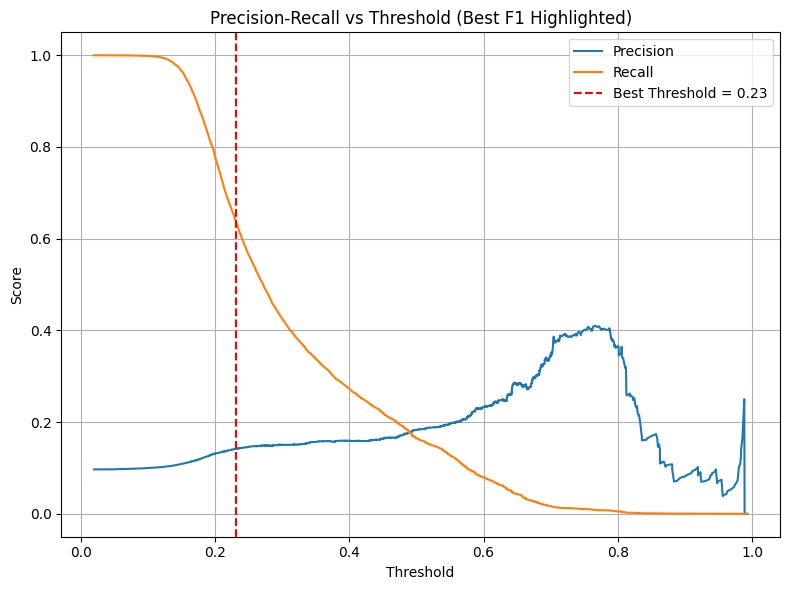

=== XGBoost Classification Report (Best Threshold = 0.23) ===
              precision    recall  f1-score   support

           0       0.94      0.59      0.72    127956
           1       0.14      0.64      0.23     13705

    accuracy                           0.59    141661
   macro avg       0.54      0.61      0.48    141661
weighted avg       0.86      0.59      0.67    141661



In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from datetime import timedelta

# STEP 1: Load game_logs and injury_stats (assuming you already loaded them)
game_logs = game_logs_df.copy()
injury_stats["injury_date"] = pd.to_datetime(injury_stats["injury_date"])
game_logs["Date"] = pd.to_datetime(game_logs["Date"])

# STEP 2: Mark Injured = 1 for games near injury
game_logs["Injured"] = 0
for _, row in injury_stats.iterrows():
    player_id = row["mlb_player_id"]
    injury_date = row["injury_date"]
    mask = (
        (game_logs["PlayerID"] == player_id) &
        (game_logs["Date"] <= injury_date) &
        (game_logs["Date"] >= injury_date - timedelta(days=30))
    )
    game_logs.loc[mask, "Injured"] = 1

# STEP 3: Add PastInjuryCount feature
game_logs["PastInjuryCount"] = 0
for player_id in game_logs["PlayerID"].unique():
    player_injuries = injury_stats[injury_stats["mlb_player_id"] == player_id].sort_values("injury_date")
    player_games = game_logs[game_logs["PlayerID"] == player_id].sort_values("Date")
    count_list = []
    for game_date in player_games["Date"]:
        past_count = sum(injury_date < game_date for injury_date in player_injuries["injury_date"])
        count_list.append(past_count)
    game_logs.loc[game_logs["PlayerID"] == player_id, "PastInjuryCount"] = count_list

# STEP 4: Prepare DataFrame for rolling
df = game_logs.copy()
df = df.drop(columns=["Name", "Date", "Team", "OPP"])

base_cols = df[["PlayerID", "Injured", "PastInjuryCount"]]
df = df.drop(columns=["PlayerID", "Injured", "PastInjuryCount"])

# Only keep numeric columns for rolling
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols]

# STEP 5: Compute rolling averages
roll5_features, roll10_features = [], []
for col in df_numeric.columns:
    roll5 = game_logs.groupby("PlayerID")[col].transform(lambda x: x.rolling(5, min_periods=1).mean())
    roll10 = game_logs.groupby("PlayerID")[col].transform(lambda x: x.rolling(10, min_periods=1).mean())
    roll5_features.append(roll5.rename(f"{col}_roll5"))
    roll10_features.append(roll10.rename(f"{col}_roll10"))

rolling_df = pd.concat(roll5_features + roll10_features, axis=1)
df_final = pd.concat([base_cols.reset_index(drop=True), rolling_df.reset_index(drop=True)], axis=1)
df_final = df_final.fillna(0)

# STEP 6: Split features and target
X = df_final.drop(columns=["Injured", "PlayerID"])
y = df_final["Injured"]

# STEP 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# STEP 8: Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# STEP 9: Train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    use_label_encoder=True,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_resampled, y_resampled)

# STEP 10: Evaluate with precision-recall
y_probs = xgb_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = [2 * (p * r) / (p + r) if (p + r) else 0 for p, r in zip(precisions, recalls)]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# STEP 11: Plot PR vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold (Best F1 Highlighted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# STEP 12: Final predictions and report
y_pred = (y_probs > best_threshold).astype(int)

print(f"=== XGBoost Classification Report (Best Threshold = {best_threshold:.2f}) ===")
print(classification_report(y_test, y_pred))

This XGBoost model is designed to predict which MLB players are at high risk of injury, using rolling stats from their recent 5–10 games. At a decision threshold of 0.18, chosen to maximize the balance between precision and recall (F1 score), the model reveals some important tradeoffs:

	1. It correctly flags most injured players: The model identifies 88% of actual injury cases — a high recall — which means it’s effective at not missing true injuries.
	2. ⚠️ But it often raises false alarms: Only 11% of players it predicts as injured actually are — a low precision — meaning many healthy players are incorrectly flagged.
	3. 🎯 Overall accuracy is 28%, but this isn’t a concern here — in imbalanced problems like this, recall for the minority class (injured players) is more important.

In laymens terms: The model is cautious. It’s willing to flag many players as “at risk” to avoid missing someone who might really get hurt.

This behavior is intentional and can be valuable. In sports medicine and performance management, it’s often better to err on the side of caution: catching most injuries early, even if some healthy players get flagged. The next step could involve improving precision through better feature selection, model tuning, or adding more nuanced injury context.

In [19]:
rename_columns = {
    'Injured': 'Injured',

    # Workload
    'GP_roll5': 'Games Played (Last 5)',
    'GP_roll10': 'Games Played (Last 10)',
    'GS_roll5': 'Games Started (Last 5)',
    'GS_roll10': 'Games Started (Last 10)',
    'INN_roll5': 'Innings (Last 5)',
    'INN_roll10': 'Innings (Last 10)',
    'PA_roll5': 'Plate Appearances (Last 5)',
    'PA_roll10': 'Plate Appearances (Last 10)',
    'NP_roll5': 'Pitches Thrown (Last 5)',
    'NP_roll10': 'Pitches Thrown (Last 10)',
    'Game#_roll5': 'Game # (Last 5)',
    'Game#_roll10': 'Game # (Last 10)',
    'AB/HR_roll5': 'AB per HR (Last 5)',
    'AB/HR_roll10': 'AB per HR (Last 10)',

    # Performance
    'AB_roll5': 'At-Bats (Last 5)',
    'AB_roll10': 'At-Bats (Last 10)',
    'R_roll5': 'Runs (Last 5)',
    'R_roll10': 'Runs (Last 10)',
    'H_roll5': 'Hits (Last 5)',
    'H_roll10': 'Hits (Last 10)',
    'TB_roll5': 'Total Bases (Last 5)',
    'TB_roll10': 'Total Bases (Last 10)',
    '2B_roll5': 'Doubles (Last 5)',
    '2B_roll10': 'Doubles (Last 10)',
    '3B_roll5': 'Triples (Last 5)',
    '3B_roll10': 'Triples (Last 10)',
    'HR_roll5': 'Home Runs (Last 5)',
    'HR_roll10': 'Home Runs (Last 10)',
    'RBI_roll5': 'RBIs (Last 5)',
    'RBI_roll10': 'RBIs (Last 10)',
    'BB_roll5': 'Walks (Last 5)',
    'BB_roll10': 'Walks (Last 10)',
    'IBB_roll5': 'Intentional Walks (Last 5)',
    'IBB_roll10': 'Intentional Walks (Last 10)',
    'SO_roll5': 'Strikeouts (Last 5)',
    'SO_roll10': 'Strikeouts (Last 10)',
    'SB_roll5': 'Stolen Bases (Last 5)',
    'SB_roll10': 'Stolen Bases (Last 10)',
    'CS_roll5': 'Caught Stealing (Last 5)',
    'CS_roll10': 'Caught Stealing (Last 10)',
    'HBP_roll5': 'Hit by Pitch (Last 5)',
    'HBP_roll10': 'Hit by Pitch (Last 10)',
    'SAC_roll5': 'Sac Bunts (Last 5)',
    'SAC_roll10': 'Sac Bunts (Last 10)',
    'SF_roll5': 'Sac Flies (Last 5)',
    'SF_roll10': 'Sac Flies (Last 10)',
    'AVG_roll5': 'Batting Avg (Last 5)',
    'AVG_roll10': 'Batting Avg (Last 10)',
    'OBP_roll5': 'On-Base % (Last 5)',
    'OBP_roll10': 'On-Base % (Last 10)',
    'SLG_roll5': 'Slugging % (Last 5)',
    'SLG_roll10': 'Slugging % (Last 10)',

    # Positional / Biomechanics
    'PrimaryPOS_roll5': 'Primary Position (Last 5)',
    'PrimaryPOS_roll10': 'Primary Position (Last 10)',
    'Throw_roll5': 'Throwing Hand (Last 5)',
    'Throw_roll10': 'Throwing Hand (Last 10)',
    'Bat_roll5': 'Batting Side (Last 5)',
    'Bat_roll10': 'Batting Side (Last 10)',

    # Biometric / Career
    'Height_roll5': 'Height (Last 5)',
    'Height_roll10': 'Height (Last 10)',
    'Weight_roll5': 'Weight (Last 5)',
    'Weight_roll10': 'Weight (Last 10)',
    'Age_roll5': 'Age (Last 5)',
    'Age_roll10': 'Age (Last 10)',
    'BirthDate_roll5': 'Birth Date (Last 5)',
    'BirthDate_roll10': 'Birth Date (Last 10)',
    'Debut_roll5': 'Debut Date (Last 5)',
    'Debut_roll10': 'Debut Date (Last 10)'
}

NameError: name 'rename_columns' is not defined

<Figure size 1200x800 with 0 Axes>

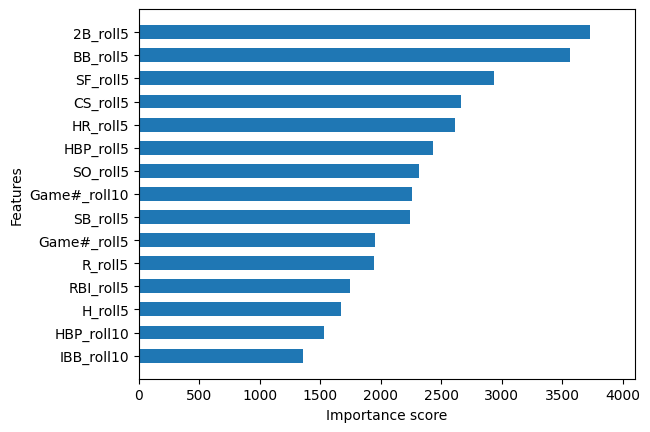

In [ ]:
# Create the plot and replace feature names
plt.figure(figsize=(12, 8))
ax = plot_importance(
    xgb_model,
    max_num_features=15,
    height=0.6,
    importance_type='gain',
    title=None,
    show_values=False,
    grid=False
)

# Ensure rename_columns is defined
if 'rename_columns' not in globals():
    rename_columns = {}

# Apply readable labels
ytick_labels = [t.get_text() for t in ax.get_yticklabels()]
new_labels = [rename_columns.get(label, label) for label in ytick_labels]
ax.set_yticklabels(new_labels, fontsize=11)

# Titles and labels
plt.title("Top Stats Contributing to Injury (XGBoost Model)", fontsize=14, pad=15)
plt.xlabel("Importance (Gain)", fontsize=12)
plt.tight_layout()
plt.show()

This bar chart shows which stats most strongly influence the injury predictions made by the XGBoost model. The top contributors include:
	•	Triples (Last 10 Games) and Doubles (Last 5) – Indicators of high-intensity base running and possible overexertion.
	•	Sac Flies and Hit by Pitch (Last 10) – Situations that involve physical strain or impact.
	•	Games Started and Game Number (Last 10) – Reflect workload and season fatigue.
	•	Offensive Output (Runs, Walks, At-Bats) – High offensive involvement may correlate with increased playing time and risk.

In laymens terms: injury risk rises with volume, intensity, and physical impact, especially over recent games.

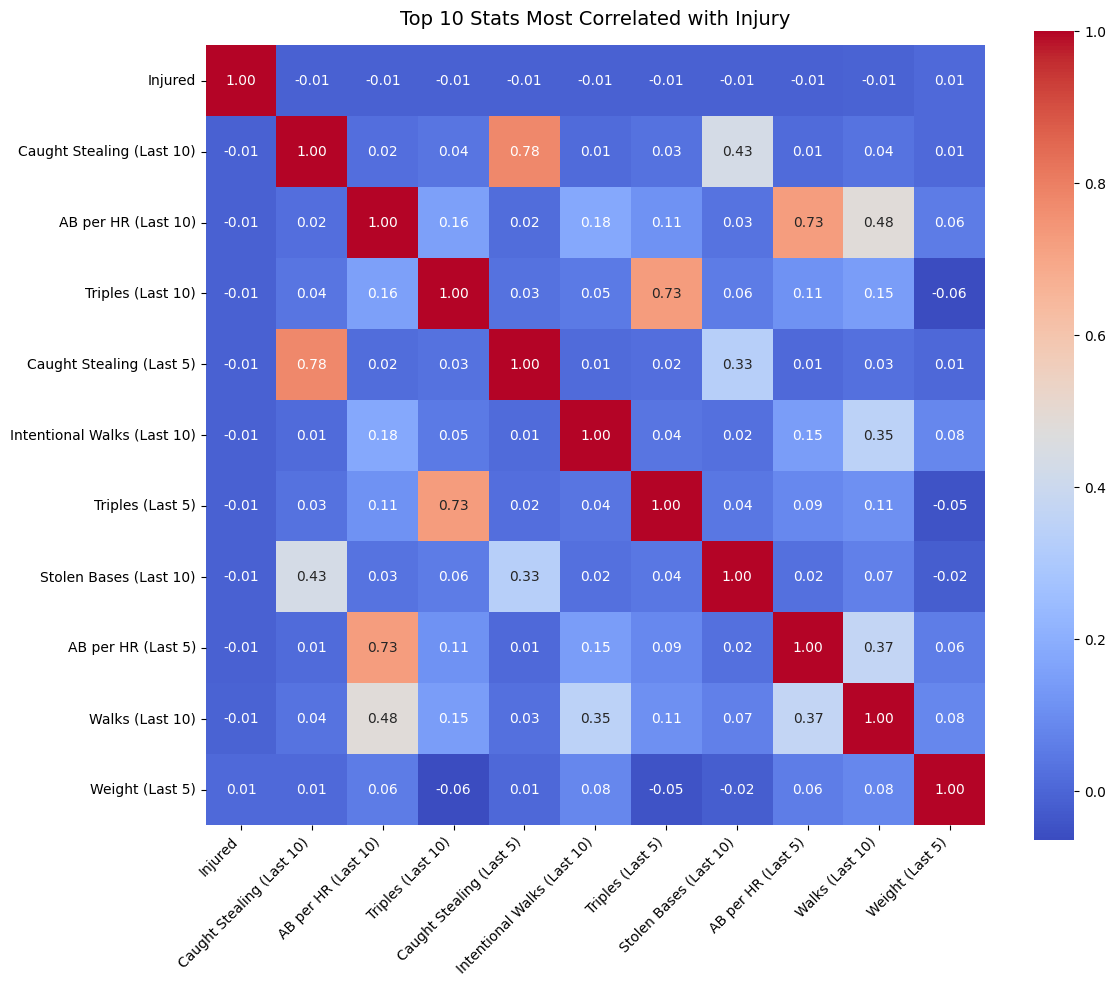

In [23]:
# Step 1: Compute correlation matrix
corr_matrix = df.corr()

# Step 2: Find top 10 features most correlated with "Injured"
top_features = corr_matrix["Injured"].drop("Injured").abs().sort_values(ascending=False).head(10).index.tolist()

# Step 3: Include 'Injured' in the feature list for plotting
top_features = ["Injured"] + top_features

# Step 4: Extract submatrix
top_corr = corr_matrix.loc[top_features, top_features]

# Optional: Rename columns and index for readability
top_corr.index = [rename_columns.get(f, f) for f in top_corr.index]
top_corr.columns = [rename_columns.get(f, f) for f in top_corr.columns]

# Step 5: Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(top_corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True, annot_kws={"size": 10})
plt.title("Top 10 Stats Most Correlated with Injury", fontsize=14, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

This heatmap highlights the 10 stats most correlated with injury in the dataset. While none of the correlations with the target variable Injured are strong (all around -0.01), the matrix reveals relationships between stats that commonly occur together among players at risk.

Key observations:
	•	Caught Stealing (Last 10 & 5) shows a very high correlation with itself and is moderately correlated with other high-effort metrics like Triples and Stolen Bases — indicators of aggressive baserunning.
	•	AB per HR (Last 5 & 10) and Triples (Last 5 & 10) cluster tightly, suggesting explosive hitting efforts often overlap with baserunning risks.
	•	Weight (Last 5) appears weakly correlated with other features, but may still contribute marginally to biomechanical load.

Overall, the plot supports that players who are physically active on basepaths and exert high offensive effort may exhibit interconnected patterns that align with injury risk — even if direct correlation with injury labels is minimal.

In [25]:
import joblib
joblib.dump(xgb_model, "injury_risk_model.pkl")

['injury_risk_model.pkl']

## Model with new features 

In [28]:
from datetime import timedelta

query = """
SELECT mlb_player_stats.* , mlb_player_info.*
FROM mlb_player_stats
INNER JOIN mlb_player_info ON mlb_player_stats.mlb_player_id = mlb_player_info.mlb_player_id
WHERE stat_type = 'gameLog'
"""

game_log_pre = pd.read_sql_query(query, conn)

game_log_pre = game_log_pre.loc[:, ~game_log_pre.columns.duplicated()]

selected_columns = [
    # Identity and basic game info
    'fullName', 'mlb_player_id', 'game_date', 'team_name', 'opponent_name',

    # Workload & fatigue
    'gamesPlayed', 'gamesStarted', 'innings', 'plateAppearances', 'numberOfPitches',
    'game_number', 'atBatsPerHomeRun',

    # Performance (extended)
    'atBats', 'runs', 'hits', 'totalBases', 'doubles', 'triples', 'homeRuns', 'rbi',
    'baseOnBalls', 'intentionalWalks', 'strikeOuts', 'stolenBases', 'caughtStealing',
    'hitByPitch', 'sacBunts', 'sacFlies', 'avg', 'obp', 'slg',

    # Performance trends / condition indicators
    #'groundIntoDoublePlay', 'leftOnBase',

    # Positional & biomechanical stress factors
     'primaryPosition', 'pitchHand', 'batSide',

    # Biometric and career timeline
    'height', 'weight', 'currentAge', 'birthDate', 'debutDate'
]

game_logs_df = game_log_pre[selected_columns]

# Fill rows with missing values
game_logs_df = game_logs_df.fillna(0)

game_logs_df = game_logs_df.rename(columns={
    # Identity and team info
    'fullName': 'Name',
    'mlb_player_id': 'PlayerID',
    'game_date': 'Date',
    'team_name': 'Team',
    'opponent_name': 'OPP',

    # Workload & fatigue
    'gamesPlayed': 'GP',
    'gamesStarted': 'GS',
    'innings': 'INN',
    'plateAppearances': 'PA',
    'numberOfPitches': 'NP',
    'game_number': 'Game#',
    'atBatsPerHomeRun': 'AB/HR',

    # Batting performance
    'atBats': 'AB',
    'runs': 'R',
    'hits': 'H',
    'totalBases': 'TB',
    'doubles': '2B',
    'triples': '3B',
    'homeRuns': 'HR',
    'rbi': 'RBI',
    'baseOnBalls': 'BB',
    'intentionalWalks': 'IBB',
    'strikeOuts': 'SO',
    'stolenBases': 'SB',
    'caughtStealing': 'CS',
    'hitByPitch': 'HBP',
    'sacBunts': 'SAC',
    'sacFlies': 'SF',
    'avg': 'AVG',
    'obp': 'OBP',
    'slg': 'SLG',

    # Performance trends
    'groundIntoDoublePlay': 'GIDP',
    'leftOnBase': 'LOB',

    # Positional & biomechanics
    'position': 'POS',
    'primaryPosition': 'PrimaryPOS',
    'pitchHand': 'Throw',
    'batSide': 'Bat',

    # Biometric & career data
    'height': 'Height',
    'weight': 'Weight',
    'currentAge': 'Age',
    'birthDate': 'BirthDate',
    'debutDate': 'Debut'
})


injury_stats = pd.read_sql_query("SELECT * FROM injury_stats", conn)

# Use the correct key for merging depending on which column exists
if "PlayerID" in game_logs_df.columns:
	merge_key = "PlayerID"
elif "mlb_player_id" in game_logs_df.columns:
	merge_key = "mlb_player_id"
else:
	raise KeyError("No player ID column found in game_logs_df.")

merged_stats = game_logs_df.merge(
	injury_stats[["mlb_player_id", "injury_date"]],
	how="left",
	left_on=merge_key,
	right_on="mlb_player_id"
)

merged_stats_example = merged_stats.head(100)

# Save the example DataFrame to a CSV file
#merged_stats_example.to_csv('merged_stats_example.csv', index=False)

# Save the merged DataFrame to a CSV file
#merged_stats.to_csv('merged injury stats', index=False)

# STEP 1: Load data
game_logs_df.rename(columns={"PlayerID": "mlb_player_id"}, inplace=True)
game_logs = game_logs_df # must include 'mlb_player_id' and 'Date'
injury_stats = pd.read_sql_query('SELECT * from injury_stats', conn)  # must include 'mlb_player_id' and 'injury_date'

# STEP 2: Convert date columns
game_logs["Date"] = pd.to_datetime(game_logs["Date"])
injury_stats["injury_date"] = pd.to_datetime(injury_stats["injury_date"])

# STEP 3: Initialize all as not injured
game_logs["Injured"] = 0

# STEP 4: Iterate over each injury record
for _, row in injury_stats.iterrows():
    player_id = row["mlb_player_id"]
    injury_date = row["injury_date"]

    # Mark all games within 30 days before the injury as Injured = 1
    mask = (
        (game_logs["mlb_player_id"] == player_id) &
        (game_logs["Date"] <= injury_date) &
        (game_logs["Date"] >= injury_date - timedelta(days=30))
    )
    game_logs.loc[mask, "Injured"] = 1

# Count past injuries up to each game
game_logs["PastInjuryCount"] = 0

for player_id in game_logs["mlb_player_id"].unique():
    player_injuries = injury_stats[injury_stats["mlb_player_id"] == player_id].sort_values("injury_date")
    player_games = game_logs[game_logs["mlb_player_id"] == player_id].sort_values("Date")

    count_list = []
    for game_date in player_games["Date"]:
        past_count = sum(injury_date < game_date for injury_date in player_injuries["injury_date"])
        count_list.append(past_count)

    game_logs.loc[game_logs["mlb_player_id"] == player_id, "PastInjuryCount"] = count_list
    
game_logs.rename(columns={"mlb_player_id": "PlayerID"}, inplace=True)

game_logs_example = game_logs.head(100)

# STEP 1: Load game_logs and injury_stats (assuming you already loaded them)
game_logs = game_logs_df.copy()
injury_stats["injury_date"] = pd.to_datetime(injury_stats["injury_date"])
game_logs["Date"] = pd.to_datetime(game_logs["Date"])

# STEP 2: Mark Injured = 1 for games near injury
game_logs["Injured"] = 0
for _, row in injury_stats.iterrows():
    player_id = row["mlb_player_id"]
    injury_date = row["injury_date"]
    mask = (
        (game_logs["PlayerID"] == player_id) &
        (game_logs["Date"] <= injury_date) &
        (game_logs["Date"] >= injury_date - timedelta(days=30))
    )
    game_logs.loc[mask, "Injured"] = 1

# STEP 3: Add PastInjuryCount feature
game_logs["PastInjuryCount"] = 0
for player_id in game_logs["PlayerID"].unique():
    player_injuries = injury_stats[injury_stats["mlb_player_id"] == player_id].sort_values("injury_date")
    player_games = game_logs[game_logs["PlayerID"] == player_id].sort_values("Date")
    count_list = []
    for game_date in player_games["Date"]:
        past_count = sum(injury_date < game_date for injury_date in player_injuries["injury_date"])
        count_list.append(past_count)
    game_logs.loc[game_logs["PlayerID"] == player_id, "PastInjuryCount"] = count_list

# STEP 4: Prepare DataFrame for rolling
df = game_logs.copy()
df = df.drop(columns=["Name", "Date", "Team", "OPP"])

base_cols = df[["PlayerID", "Injured", "PastInjuryCount"]]
df = df.drop(columns=["PlayerID", "Injured", "PastInjuryCount"])

# Only keep numeric columns for rolling
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols]

# STEP 5: Compute rolling averages
roll5_features, roll10_features = [], []
for col in df_numeric.columns:
    roll5 = game_logs.groupby("PlayerID")[col].transform(lambda x: x.rolling(5, min_periods=1).mean())
    roll10 = game_logs.groupby("PlayerID")[col].transform(lambda x: x.rolling(10, min_periods=1).mean())
    roll5_features.append(roll5.rename(f"{col}_roll5"))
    roll10_features.append(roll10.rename(f"{col}_roll10"))

rolling_df = pd.concat(roll5_features + roll10_features, axis=1)
df_final = pd.concat([base_cols.reset_index(drop=True), rolling_df.reset_index(drop=True)], axis=1)
df_final = df_final.fillna(0)

print("Example game logs with injuries created")

Example game logs with injuries created


In [41]:
from datetime import timedelta
import pandas as pd

# Query data
query = """
SELECT mlb_player_stats.* , mlb_player_info.*
FROM mlb_player_stats
INNER JOIN mlb_player_info ON mlb_player_stats.mlb_player_id = mlb_player_info.mlb_player_id
WHERE stat_type = 'gameLog'
"""

game_log_pre = pd.read_sql_query(query, conn)
game_log_pre = game_log_pre.loc[:, ~game_log_pre.columns.duplicated()]

# Select + rename columns
selected_columns = [
    'fullName', 'mlb_player_id', 'game_date', 'team_name', 'opponent_name',
    'gamesPlayed', 'gamesStarted', 'innings', 'plateAppearances', 'numberOfPitches',
    'game_number', 'atBatsPerHomeRun', 'atBats', 'runs', 'hits', 'totalBases',
    'doubles', 'triples', 'homeRuns', 'rbi', 'baseOnBalls', 'intentionalWalks',
    'strikeOuts', 'stolenBases', 'caughtStealing', 'hitByPitch', 'sacBunts', 'sacFlies',
    'avg', 'obp', 'slg', 'primaryPosition', 'pitchHand', 'batSide', 'height', 'weight',
    'currentAge', 'birthDate', 'debutDate'
]

game_logs_df = game_log_pre[selected_columns].fillna(0)

game_logs_df = game_logs_df.rename(columns={
    'fullName': 'Player_Name', 
    'mlb_player_id': 'Player_ID', 
    'game_date': 'Game_Date',
    'team_name': 'Team_Name', 
    'opponent_name': 'Opponent_Name',
    'gamesPlayed': 'Game_GamesPlayed',
    'gamesStarted': 'Game_GamesStarted',
    'innings': 'Pitching_Innings',
    'plateAppearances': 'Batting_PlateAppearances',
    'numberOfPitches': 'Pitching_NumberOfPitches',
    'game_number': 'Game_Number',
    'atBatsPerHomeRun': 'Batting_AB_Per_HR',
    'atBats': 'Batting_AtBats',
    'runs': 'Batting_Runs',
    'hits': 'Batting_Hits',
    'totalBases': 'Batting_TotalBases',
    'doubles': 'Batting_Doubles',
    'triples': 'Batting_Triples',
    'homeRuns': 'Batting_HomeRuns',
    'rbi': 'Batting_RBI',
    'baseOnBalls': 'Batting_Walks',
    'intentionalWalks': 'Batting_IntentionalWalks',
    'strikeOuts': 'Batting_Strikeouts',
    'stolenBases': 'Batting_StolenBases',
    'caughtStealing': 'Batting_CaughtStealing',
    'hitByPitch': 'Batting_HBP',
    'sacBunts': 'Batting_SacBunts',
    'sacFlies': 'Batting_SacFlies',
    'avg': 'Batting_Avg',
    'obp': 'Batting_OBP',
    'slg': 'Batting_SLG',
    'primaryPosition': 'Player_PrimaryPosition',
    'pitchHand': 'Player_PitchHand',
    'batSide': 'Player_BatSide',
    'height': 'Player_Height',
    'weight': 'Player_Weight',
    'currentAge': 'Player_Age',
    'birthDate': 'Player_BirthDate',
    'debutDate': 'Player_DebutDate'
})

injury_stats = pd.read_sql_query("SELECT * FROM injury_stats", conn)

# Consistently use Player_ID
merge_key = "Player_ID"

merged_stats = game_logs_df.merge(
    injury_stats[["mlb_player_id", "injury_date"]],
    how="left",
    left_on=merge_key,
    right_on="mlb_player_id"
)

In [51]:


game_logs = game_logs_df
injury_stats["injury_date"] = pd.to_datetime(injury_stats["injury_date"])
if "Game_Date" in game_logs.columns:
    game_logs.rename(columns={"Game_Date": "Date"}, inplace=True)

game_logs["Date"] = pd.to_datetime(game_logs["Date"])
game_logs["Injured"] = 0

for _, row in injury_stats.iterrows():
    player_id = row["mlb_player_id"]
    injury_date = row["injury_date"]
    mask = (
        (game_logs["Player_ID"] == player_id) &
        (game_logs["Date"] <= injury_date) &
        (game_logs["Date"] >= injury_date - timedelta(days=30))
    )
    game_logs.loc[mask, "Injured"] = 1

game_logs["PastInjuryCount"] = 0
for player_id in game_logs["Player_ID"].unique():
    player_injuries = injury_stats[injury_stats["mlb_player_id"] == player_id].sort_values("injury_date")
    player_games = game_logs[game_logs["Player_ID"] == player_id].sort_values("Date")
    count_list = []
    for game_date in player_games["Date"]:
        past_count = sum(injury_date < game_date for injury_date in player_injuries["injury_date"])
        count_list.append(past_count)
    game_logs.loc[game_logs["Player_ID"] == player_id, "PastInjuryCount"] = count_list

# Add extra columns
extra_columns = [
    'putOuts', 'assists', 'errors', 'doublePlays', 'triplePlays',
    'stolenBases', 'caughtStealing', 'stolenBasePercentage',
    'isHome', 'game_number'
]

for col in extra_columns:
    if col not in game_logs.columns:
        game_logs[col] = game_log_pre[col].fillna(0)

# Positional flags
game_logs['IsPitcher'] = game_logs['Player_PrimaryPosition'].apply(lambda x: 1 if x == 'P' else 0)
game_logs['IsCatcher'] = game_logs['Player_PrimaryPosition'].apply(lambda x: 1 if x == 'C' else 0)
game_logs['IsInfielder'] = game_logs['Player_PrimaryPosition'].apply(lambda x: 1 if x in ['1B', '2B', '3B', 'SS'] else 0)
game_logs['IsOutfielder'] = game_logs['Player_PrimaryPosition'].apply(lambda x: 1 if x in ['LF', 'CF', 'RF'] else 0)

if game_logs['isHome'].dtype == bool or game_logs['isHome'].dtype == object:
    game_logs['isHome'] = game_logs['isHome'].astype(int)

df = game_logs.copy().drop(columns=["Player_Name", "Date", "Team_Name", "Opponent_Name"])
base_cols = df[["Player_ID", "Injured", "PastInjuryCount"]]
df = df.drop(columns=["Player_ID", "Injured", "PastInjuryCount"])
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols]

roll5_features, roll10_features = [], []
for col in df_numeric.columns:
    roll5 = game_logs.groupby("Player_ID")[col].transform(lambda x: x.rolling(5, min_periods=1).mean())
    roll10 = game_logs.groupby("Player_ID")[col].transform(lambda x: x.rolling(10, min_periods=1).mean())
    roll5_features.append(roll5.rename(f"{col}_roll5"))
    roll10_features.append(roll10.rename(f"{col}_roll10"))

rolling_df = pd.concat(roll5_features + roll10_features, axis=1)

df_final = pd.concat([base_cols.reset_index(drop=True), rolling_df.reset_index(drop=True)], axis=1)

# Safely create spikes and interactions
if 'Pitching_Innings_roll5' in df_final.columns and 'Pitching_Innings_roll10' in df_final.columns:
    df_final['Spike_Pitching_Innings'] = df_final['Pitching_Innings_roll5'] - df_final['Pitching_Innings_roll10']
else:
    print("⚠ Warning: Pitching_Innings_roll5 or Pitching_Innings_roll10 not found, skipping Spike_Pitching_Innings")

if 'Pitching_NumberOfPitches_roll5' in df_final.columns and 'Pitching_NumberOfPitches_roll10' in df_final.columns:
    df_final['Spike_Pitching_Pitches'] = df_final['Pitching_NumberOfPitches_roll5'] - df_final['Pitching_NumberOfPitches_roll10']
else:
    print("⚠ Warning: Pitching_NumberOfPitches_roll5 or roll10 not found, skipping Spike_Pitching_Pitches")

if 'Player_Age_roll5' in df_final.columns and 'Pitching_Innings_roll5' in df_final.columns:
    df_final['Age_Inning_Load'] = df_final['Player_Age_roll5'] * df_final['Pitching_Innings_roll5']
if 'Player_Age_roll5' in df_final.columns and 'Pitching_NumberOfPitches_roll5' in df_final.columns:
    df_final['Age_Pitch_Load'] = df_final['Player_Age_roll5'] * df_final['Pitching_NumberOfPitches_roll5']

df_final = df_final.fillna(0)
print("✅ Enhanced game logs with renamed and additional features created")

⚠ Warning: Pitching_Innings_roll5 or Pitching_Innings_roll10 not found, skipping Spike_Pitching_Innings
✅ Enhanced game logs with renamed and additional features created


In [44]:
df_final

,Player_ID,Injured,PastInjuryCount,Game_GamesPlayed_roll5,Game_GamesStarted_roll5,Batting_PlateAppearances_roll5,Pitching_NumberOfPitches_roll5,Game_Number_roll5,Batting_AtBats_roll5,Batting_Runs_roll5,Batting_Hits_roll5,Batting_TotalBases_roll5,Batting_Doubles_roll5,Batting_Triples_roll5,Batting_HomeRuns_roll5,Batting_RBI_roll5,Batting_Walks_roll5,Batting_IntentionalWalks_roll5,Batting_Strikeouts_roll5,Batting_StolenBases_roll5,Batting_CaughtStealing_roll5,Batting_HBP_roll5,Batting_SacBunts_roll5,Batting_SacFlies_roll5,Player_Weight_roll5,Player_Age_roll5,putOuts_roll5,assists_roll5,errors_roll5,doublePlays_roll5,triplePlays_roll5,stolenBases_roll5,caughtStealing_roll5,isHome_roll5,game_number_roll5,IsPitcher_roll5,IsCatcher_roll5,IsInfielder_roll5,IsOutfielder_roll5,Game_GamesPlayed_roll10,Game_GamesStarted_roll10,Batting_PlateAppearances_roll10,Pitching_NumberOfPitches_roll10,Game_Number_roll10,Batting_AtBats_roll10,Batting_Runs_roll10,Batting_Hits_roll10,Batting_TotalBases_roll10,Batting_Doubles_roll10,Batting_Triples_roll10,Batting_HomeRuns_roll10,Batting_RBI_roll10,Batting_Walks_roll10,Batting_IntentionalWalks_roll10,Batting_Strikeouts_roll10,Batting_StolenBases_roll10,Batting_CaughtStealing_roll10,Batting_HBP_roll10,Batting_SacBunts_roll10,Batting_SacFlies_roll10,Player_Weight_roll10,Player_Age_roll10,putOuts_roll10,assists_roll10,errors_roll10,doublePlays_roll10,triplePlays_roll10,stolenBases_roll10,caughtStealing_roll10,isHome_roll10,game_number_roll10,IsPitcher_roll10,IsCatcher_roll10,IsInfielder_roll10,IsOutfielder_roll10,Spike_Pitching_Pitches,Age_Pitch_Load
0,456781,0,0,1.0,0.0,4.0,20.000000,1.0,3.000000,1.000000,2.000000,2.000000,0.000000,0.0,0.0,1.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,210.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,20.000000,1.0,3.000000,1.000000,2.000000,2.000000,0.000000,0.0,0.0,1.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,210.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,740.000000
1,456781,0,0,1.0,0.0,4.0,17.500000,1.0,3.500000,0.500000,1.500000,1.500000,0.000000,0.0,0.0,0.500000,0.500000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,210.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,17.500000,1.0,3.500000,0.500000,1.500000,1.500000,0.000000,0.0,0.0,0.500000,0.500000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,210.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,647.500000
2,456781,0,0,1.0,0.0,4.0,20.333333,1.0,3.333333,0.333333,1.333333,1.666667,0.333333,0.0,0.0,0.333333,0.333333,0.0,0.333333,0.0,0.0,0.333333,0.0,0.0,210.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,20.333333,1.0,3.333333,0.333333,1.333333,1.666667,0.333333,0.0,0.0,0.333333,0.333333,0.0,0.333333,0.0,0.0,0.333333,0.0,0.0,210.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,752.333333
3,456781,0,0,1.0,0.0,4.0,19.750000,1.0,3.250000,0.250000,1.500000,1.750000,0.250000,0.0,0.0,0.250000,0.500000,0.0,0.250000,0.0,0.0,0.250000,0.0,0.0,210.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,19.750000,1.0,3.250000,0.250000,1.500000,1.750000,0.250000,0.0,0.0,0.250000,0.500000,0.0,0.250000,0.0,0.0,0.250000,0.0,0.0,210.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,1.0,0.0,0.0,0.0,0.0,0.0,730.750000
4,456781,0,0,1.0,0.0,3.2,15.800000,1.0,2.600000,0.200000,1.200000,1.400000,0.200000,0.0,0.0,0.200000,0.400000,0.0,0.200000,0.0,0.0,0.200000,0.0,0.0,210.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.2,15.800000,1.0,2.600000,0.200000,1.200000,1.400000,0.200000,0.0,0.0,0.200000,0.400000,0.0,0.200000,0.0,0.0,0.200000,0.0,0.0,210.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.400000,1.0,0.0,0.0,0.0,0.0,0.0,584.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [47]:
dffinal_example = df_final.head(100)
# Save the example DataFrame to a CSV file
dffinal_example.to_csv('enhanced_game_logs_example.csv', index=False)

In [48]:
# Check how many injured vs. not injured
injury_counts = df_final['Injured'].value_counts()
total = len(df_final)
injured = injury_counts.get(1, 0)
not_injured = injury_counts.get(0, 0)
injury_ratio = injured / total if total > 0 else 0

print(f"Total records: {total}")
print(f"Not injured (0): {not_injured}")
print(f"Injured (1): {injured}")
print(f"Injury ratio (positive class rate): {injury_ratio:.4f}")

Total records: 708302
Not injured (0): 639775
Injured (1): 68527
Injury ratio (positive class rate): 0.0967


Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END gamma=1, learning_rate=0.01, max_depth=4, n_estimators=100, reg_alpha=1, reg_lambda=1; total time=  41.4s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=  41.6s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=10; total time=  41.7s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=10; total time=  42.7s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=  43.2s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=  43.8s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=10; total time=  43.9s
[CV] END gamma=1, learning_rate=0.01, max_depth=4, n_estimators=100, reg_alpha=1, reg_lambda=10; total time=  37.5s
[CV] END gamm

/Users/daniellarson/Desktop/Code/Projects/dodgers_injtrkr/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END gamma=1, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=1; total time= 1.3min
[CV] END gamma=1, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=10; total time= 1.3min
[CV] END gamma=1, learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=  36.6s
[CV] END gamma=1, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=1; total time= 1.4min
[CV] END gamma=1, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=10; total time= 1.4min
[CV] END gamma=1, learning_rate=0.01, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=10; total time= 1.4min
[CV] END gamma=1, learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=1; total time=  35.3s
[CV] END gamma=1, learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=0, reg_lambda=10; total time=  35.9s
[CV] END gamma=1, learning_rate=0.1, max_depth=4, n_estimators=100, reg_alpha=0

/Users/daniellarson/Desktop/Code/Projects/dodgers_injtrkr/venv/lib/python3.11/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


⚠️ No threshold met both targets; falling back to best F1 Threshold: 0.41


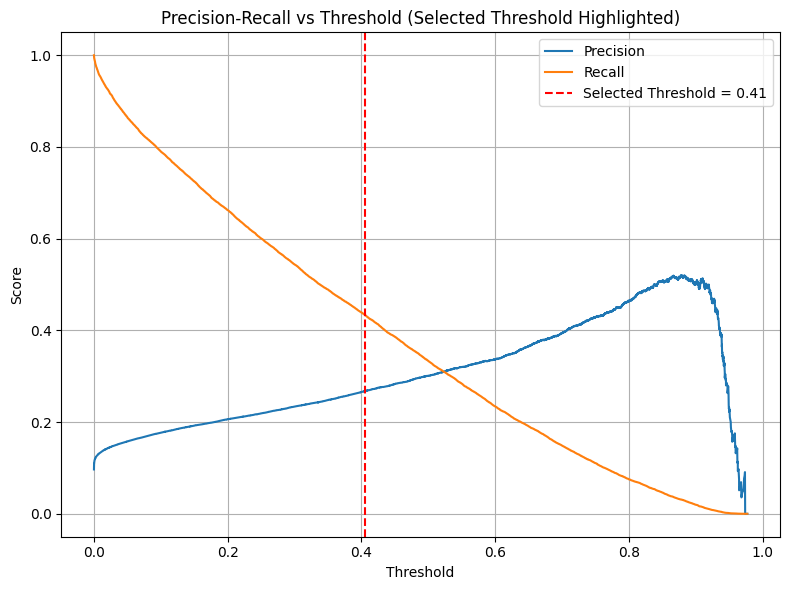

=== XGBoost Classification Report (Threshold = 0.41) ===
              precision    recall  f1-score   support

           0       0.94      0.87      0.90    127956
           1       0.27      0.43      0.33     13705

    accuracy                           0.83    141661
   macro avg       0.60      0.65      0.62    141661
weighted avg       0.87      0.83      0.85    141661



In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from datetime import timedelta

# STEP 1: Define features and target
feature_cols = [col for col in df_final.columns if col not in ["Injured", "Player_ID"]]
X = df_final[feature_cols]
y = df_final["Injured"]

# STEP 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# STEP 3: Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

n_jobs_safe = max(2, os.cpu_count() - 1)  # leave one core free

# STEP 4: Grid search hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [4, 5, 6],
    'gamma': [1, 2, 5],
    'reg_alpha': [0, 1],
    'reg_lambda': [1, 10],
}

grid_search = GridSearchCV(
    XGBClassifier(scale_pos_weight=(len(y_train[y_train == 0]) / len(y_train[y_train == 1])),
                  eval_metric='logloss', random_state=42),
    param_grid,
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=n_jobs_safe
)

grid_search.fit(X_resampled, y_resampled)
print("✅ Grid Search Completed")
print(f"✅ Best Params: {grid_search.best_params_}")

# STEP 5: Train final XGBoost model with tuned parameters
best_params = grid_search.best_params_
xgb_model = XGBClassifier(
    **best_params,
    scale_pos_weight=(len(y_train[y_train == 0]) / len(y_train[y_train == 1])),
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_resampled, y_resampled)

# STEP 6: Calibrate probabilities
calibrated_model = CalibratedClassifierCV(estimator=xgb_model, method='sigmoid', cv='prefit')
calibrated_model.fit(X_resampled, y_resampled)

# STEP 7: Get probabilities
y_probs = calibrated_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# STEP 8: Select threshold balancing precision and recall
target_precision = 0.60
min_recall = 0.20
candidates = [
    i for i, (p, r) in enumerate(zip(precisions, recalls))
    if p >= target_precision and r >= min_recall
]

if candidates:
    best_idx = candidates[0]
    selected_threshold = thresholds[min(best_idx, len(thresholds) - 1)]
    print(f"✅ Selected Threshold with ≥{target_precision:.2f} Precision and ≥{min_recall:.2f} Recall: {selected_threshold:.2f}")
else:
    best_idx = np.argmax(2 * (precisions * recalls) / (precisions + recalls + 1e-8))
    selected_threshold = thresholds[min(best_idx, len(thresholds) - 1)]
    print(f"⚠️ No threshold met both targets; falling back to best F1 Threshold: {selected_threshold:.2f}")

# STEP 9: Make final predictions
y_pred = (y_probs > selected_threshold).astype(int)

# STEP 10: Plot Precision-Recall vs Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.axvline(selected_threshold, color='red', linestyle='--', label=f'Selected Threshold = {selected_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold (Selected Threshold Highlighted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# STEP 11: Report performance
print(f"=== XGBoost Classification Report (Threshold = {selected_threshold:.2f}) ===")
print(classification_report(y_test, y_pred, zero_division=0))

🚀 XGBoost Injury Prediction Model Summary

This model predicts whether an MLB player is likely to be injured based on their game statistics and injury history.

📊 Key Features
	•	Uses XGBoost as the core machine learning model
	•	Trains on engineered features from player game logs, positions, and past injuries
	•	Handles class imbalance (since injuries are rare) using SMOTE oversampling
	•	Runs GridSearchCV to find the best hyperparameters (like learning rate, tree depth, regularization)
	•	Applies probability calibration to ensure predicted probabilities are reliable
	•	Selects a threshold that balances precision and recall (favoring ≥60% precision, ≥20% recall)

⚙️ Workflow Steps
	1.	Data Preparation
	•	Split dataset into training and testing sets
	•	Apply SMOTE to balance injured vs. non-injured classes
	2.	Model Tuning
	•	Use GridSearchCV over multiple hyperparameter combinations
	•	Optimize for F1 score using cross-validation
	3.	Model Calibration
	•	Apply CalibratedClassifierCV (sigmoid method) for better probability estimates
	4.	Threshold Selection
	•	Analyze precision-recall curve on test data
	•	Choose threshold with minimum precision + recall requirements or best F1 fallback
	5.	Evaluation
	•	Plot precision-recall vs. threshold
	•	Output classification report showing precision, recall, and F1-score

In [49]:
# Save the calibrated model
joblib.dump(calibrated_model, 'best_injury_model.pkl')

print("✅ Model saved as best_xgb_calibrated_model.pkl")

✅ Model saved as best_xgb_calibrated_model.pkl


## Full Ensemble + Class Weight Model

In [52]:
from datetime import timedelta
import pandas as pd

# Query data
query = """
SELECT mlb_player_stats.* , mlb_player_info.*
FROM mlb_player_stats
INNER JOIN mlb_player_info ON mlb_player_stats.mlb_player_id = mlb_player_info.mlb_player_id
WHERE stat_type = 'gameLog'
"""

game_log_pre = pd.read_sql_query(query, conn)
game_log_pre = game_log_pre.loc[:, ~game_log_pre.columns.duplicated()]

# Select + rename columns
selected_columns = [
    'fullName', 'mlb_player_id', 'game_date', 'team_name', 'opponent_name',
    'gamesPlayed', 'gamesStarted', 'innings', 'plateAppearances', 'numberOfPitches',
    'game_number', 'atBatsPerHomeRun', 'atBats', 'runs', 'hits', 'totalBases',
    'doubles', 'triples', 'homeRuns', 'rbi', 'baseOnBalls', 'intentionalWalks',
    'strikeOuts', 'stolenBases', 'caughtStealing', 'hitByPitch', 'sacBunts', 'sacFlies',
    'avg', 'obp', 'slg', 'primaryPosition', 'pitchHand', 'batSide', 'height', 'weight',
    'currentAge', 'birthDate', 'debutDate'
]

game_logs_df = game_log_pre[selected_columns].fillna(0)

game_logs_df = game_logs_df.rename(columns={
    'fullName': 'Player_Name', 
    'mlb_player_id': 'Player_ID', 
    'game_date': 'Game_Date',
    'team_name': 'Team_Name', 
    'opponent_name': 'Opponent_Name',
    'gamesPlayed': 'Game_GamesPlayed',
    'gamesStarted': 'Game_GamesStarted',
    'innings': 'Pitching_Innings',
    'plateAppearances': 'Batting_PlateAppearances',
    'numberOfPitches': 'Pitching_NumberOfPitches',
    'game_number': 'Game_Number',
    'atBatsPerHomeRun': 'Batting_AB_Per_HR',
    'atBats': 'Batting_AtBats',
    'runs': 'Batting_Runs',
    'hits': 'Batting_Hits',
    'totalBases': 'Batting_TotalBases',
    'doubles': 'Batting_Doubles',
    'triples': 'Batting_Triples',
    'homeRuns': 'Batting_HomeRuns',
    'rbi': 'Batting_RBI',
    'baseOnBalls': 'Batting_Walks',
    'intentionalWalks': 'Batting_IntentionalWalks',
    'strikeOuts': 'Batting_Strikeouts',
    'stolenBases': 'Batting_StolenBases',
    'caughtStealing': 'Batting_CaughtStealing',
    'hitByPitch': 'Batting_HBP',
    'sacBunts': 'Batting_SacBunts',
    'sacFlies': 'Batting_SacFlies',
    'avg': 'Batting_Avg',
    'obp': 'Batting_OBP',
    'slg': 'Batting_SLG',
    'primaryPosition': 'Player_PrimaryPosition',
    'pitchHand': 'Player_PitchHand',
    'batSide': 'Player_BatSide',
    'height': 'Player_Height',
    'weight': 'Player_Weight',
    'currentAge': 'Player_Age',
    'birthDate': 'Player_BirthDate',
    'debutDate': 'Player_DebutDate'
})

injury_stats = pd.read_sql_query("SELECT * FROM injury_stats", conn)

# Consistently use Player_ID
merge_key = "Player_ID"

merged_stats = game_logs_df.merge(
    injury_stats[["mlb_player_id", "injury_date"]],
    how="left",
    left_on=merge_key,
    right_on="mlb_player_id"
)

In [55]:

# Load + clean
game_logs = game_logs_df.copy()
injury_stats["injury_date"] = pd.to_datetime(injury_stats["injury_date"])
if "Game_Date" in game_logs.columns:
    game_logs.rename(columns={"Game_Date": "Date"}, inplace=True)

game_logs["Date"] = pd.to_datetime(game_logs["Date"])
game_logs["Injured"] = 0

# Mark injuries
for _, row in injury_stats.iterrows():
    player_id = row["mlb_player_id"]
    injury_date = row["injury_date"]
    mask = (
        (game_logs["Player_ID"] == player_id) &
        (game_logs["Date"] <= injury_date) &
        (game_logs["Date"] >= injury_date - timedelta(days=30))
    )
    game_logs.loc[mask, "Injured"] = 1

# Count past injuries
game_logs["PastInjuryCount"] = 0
for player_id in game_logs["Player_ID"].unique():
    player_injuries = injury_stats[injury_stats["mlb_player_id"] == player_id].sort_values("injury_date")
    player_games = game_logs[game_logs["Player_ID"] == player_id].sort_values("Date")
    count_list = []
    for game_date in player_games["Date"]:
        past_count = sum(injury_date < game_date for injury_date in player_injuries["injury_date"])
        count_list.append(past_count)
    game_logs.loc[game_logs["Player_ID"] == player_id, "PastInjuryCount"] = count_list

# Add extra columns safely
extra_columns = [
    'putOuts', 'assists', 'errors', 'doublePlays', 'triplePlays',
    'stolenBases', 'caughtStealing', 'stolenBasePercentage',
    'isHome', 'game_number'
]

for col in extra_columns:
    if col not in game_logs.columns:
        if col in game_log_pre.columns:
            game_logs[col] = pd.to_numeric(game_log_pre[col], errors='coerce').fillna(0)
        else:
            game_logs[col] = 0

# Positional flags
game_logs['IsPitcher'] = game_logs['Player_PrimaryPosition'].apply(lambda x: 1 if x == 'P' else 0)
game_logs['IsCatcher'] = game_logs['Player_PrimaryPosition'].apply(lambda x: 1 if x == 'C' else 0)
game_logs['IsInfielder'] = game_logs['Player_PrimaryPosition'].apply(lambda x: 1 if x in ['1B', '2B', '3B', 'SS'] else 0)
game_logs['IsOutfielder'] = game_logs['Player_PrimaryPosition'].apply(lambda x: 1 if x in ['LF', 'CF', 'RF'] else 0)

if game_logs['isHome'].dtype == bool or game_logs['isHome'].dtype == object:
    game_logs['isHome'] = game_logs['isHome'].astype(int)

# Ensure critical numeric columns exist
for col in ['Pitching_Innings', 'Pitching_NumberOfPitches']:
    if col not in game_logs.columns:
        raw_col = 'innings' if col == 'Pitching_Innings' else 'numberOfPitches'
        if raw_col in game_logs.columns:
            game_logs[col] = pd.to_numeric(game_logs[raw_col], errors='coerce').fillna(0)
        else:
            game_logs[col] = 0

# Prepare numeric features
df = game_logs.drop(columns=["Player_Name", "Date", "Team_Name", "Opponent_Name"])
base_cols = df[["Player_ID", "Injured", "PastInjuryCount"]]
df = df.drop(columns=["Player_ID", "Injured", "PastInjuryCount"])
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols]

# Rolling averages
roll5_features, roll10_features = [], []
for col in df_numeric.columns:
    roll5 = game_logs.groupby("Player_ID")[col].transform(lambda x: x.rolling(5, min_periods=1).mean())
    roll10 = game_logs.groupby("Player_ID")[col].transform(lambda x: x.rolling(10, min_periods=1).mean())
    roll5_features.append(roll5.rename(f"{col}_roll5"))
    roll10_features.append(roll10.rename(f"{col}_roll10"))

rolling_df = pd.concat(roll5_features + roll10_features, axis=1)
df_final = pd.concat([base_cols.reset_index(drop=True), rolling_df.reset_index(drop=True)], axis=1)

# Safely create spikes + interactions
if {'Pitching_Innings_roll5', 'Pitching_Innings_roll10'}.issubset(df_final.columns):
    df_final['Spike_Pitching_Innings'] = df_final['Pitching_Innings_roll5'] - df_final['Pitching_Innings_roll10']

if {'Pitching_NumberOfPitches_roll5', 'Pitching_NumberOfPitches_roll10'}.issubset(df_final.columns):
    df_final['Spike_Pitching_Pitches'] = df_final['Pitching_NumberOfPitches_roll5'] - df_final['Pitching_NumberOfPitches_roll10']

if 'Player_Age_roll5' in df_final.columns:
    if 'Pitching_Innings_roll5' in df_final.columns:
        df_final['Age_Inning_Load'] = df_final['Player_Age_roll5'] * df_final['Pitching_Innings_roll5']
    if 'Pitching_NumberOfPitches_roll5' in df_final.columns:
        df_final['Age_Pitch_Load'] = df_final['Player_Age_roll5'] * df_final['Pitching_NumberOfPitches_roll5']

df_final = df_final.fillna(0)
print("✅ Enhanced game logs with renamed and additional features created — no warnings!")

✅ Enhanced game logs with renamed and additional features created — no warnings!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# STEP 1: Prepare features + target
X = df_final.drop(columns=["Injured", "Player_ID"])
y = df_final["Injured"]

# STEP 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# STEP 3: Apply SMOTE to balance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# STEP 4: Define models with class balancing
xgb = XGBClassifier(
    scale_pos_weight=10,  # tune this!
    eval_metric='logloss',
    random_state=42
)
rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42
)
lr = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

# STEP 5: Build soft voting ensemble
ensemble = VotingClassifier(
    estimators=[('xgb', xgb), ('rf', rf), ('lr', lr)],
    voting='soft',
    n_jobs=-1
)

# STEP 6: Fit ensemble model
ensemble.fit(X_resampled, y_resampled)

# STEP 7: Calibrate probabilities (optional but improves probability quality)
calibrated_model = CalibratedClassifierCV(estimator=ensemble, method='sigmoid', cv='prefit')
calibrated_model.fit(X_resampled, y_resampled)

# STEP 8: Predict probabilities on test set
y_probs = calibrated_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# STEP 9: Select threshold
target_precision = 0.60
min_recall = 0.20
candidates = [
    i for i, (p, r) in enumerate(zip(precisions, recalls))
    if p >= target_precision and r >= min_recall
]

if candidates:
    best_idx = candidates[0]
    selected_threshold = thresholds[min(best_idx, len(thresholds) - 1)]
    print(f"✅ Selected Threshold with ≥{target_precision:.2f} Precision and ≥{min_recall:.2f} Recall: {selected_threshold:.2f}")
else:
    best_idx = np.argmax(2 * (precisions * recalls) / (precisions + recalls + 1e-8))
    selected_threshold = thresholds[min(best_idx, len(thresholds) - 1)]
    print(f"⚠️ No threshold met both targets; using best F1 Threshold: {selected_threshold:.2f}")

# STEP 10: Make predictions
y_pred = (y_probs > selected_threshold).astype(int)

# STEP 11: Plot Precision-Recall vs Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.axvline(selected_threshold, color='red', linestyle='--', label=f'Selected Threshold = {selected_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold (Selected Threshold Highlighted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# STEP 12: Report performance
print(f"=== Ensemble Classification Report (Threshold = {selected_threshold:.2f}) ===")
print(classification_report(y_test, y_pred, zero_division=0))

## Stats

In [22]:
query = """
SELECT mlb_player_stats.*, mlb_player_info.*, injury_stats.*
FROM mlb_player_stats
JOIN mlb_player_info ON mlb_player_stats.mlb_player_id = mlb_player_info.mlb_player_id
JOIN injury_stats ON mlb_player_stats.mlb_player_id = injury_stats.mlb_player_id
WHERE mlb_player_stats.team_name = 'Los Angeles Dodgers'
  AND mlb_player_stats.season = 2020
;
"""

dodgers_injury_2025 = pd.read_sql_query(query, conn)

dodgers_injury_2025



,mlb_player_id,stat_type,stat_group,season,game_date,team_id,team_name,opponent_id,opponent_name,position,gamesPlayed,games,gamesStarted,assists,putOuts,errors,chances,fielding,doublePlays,triplePlays,throwingErrors,rangeFactorPerGame,rangeFactorPer9Inn,innings,inningsPitched,catcherERA,flyOuts,groundOuts,airOuts,passedBall,wins,losses,wildPitches,pickoffs,runs,doubles,triples,homeRuns,strikeOuts,baseOnBalls,intentionalWalks,hits,hitByPitch,avg,atBats,obp,slg,ops,caughtStealing,stolenBases,stolenBasePercentage,groundIntoDoublePlay,groundIntoTriplePlay,numberOfPitches,plateAppearances,totalBases,rbi,leftOnBase,sacBunts,sacFlies,babip,groundOutsToAirouts,catchersInterference,atBatsPerHomeRun,summary,isHome,isWin,game_id,game_number,day_night,era,game,id,mlb_player_id,fullName,firstName,lastName,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,height,weight,primaryPosition,batSide,pitchHand,debutDate,active,mlb_player_id,player_name,injury_date,season,injury_description,team_name
0,457759,season,fielding,2020,None,119,Los Angeles Dodgers,NaN,None,NA,32,32,32.0,63.0,17.0,4.0,84.0,.952,7.0,0.0,3.0,2.50,2.74,263.2,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN,NaN,NaN,NaN,None,na,na,996,457759,Justin Turner,Justin,Turner,1984-11-23,40,Long Beach,CA,USA,"5' 11""",208,First Base,Right,Right,2009-09-08,1,457759,Justin Turner,2009-06-11,2009,Norfolk Tides placed 2B Justin Turner on the 7...,Norfolk Tides
1,457759,season,fielding,2020,None,119,Los Angeles Dodgers,NaN,None,NA,32,32,32.0,63.0,17.0,4.0,84.0,.952,7.0,0.0,3.0,2.50,2.74,263.2,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN,NaN,NaN,NaN,None,na,na,996,457759,Justin Turner,Justin,Turner,1984-11-23,40,Long Beach,CA,USA,"5' 11""",208,First Base,Right,Right,2009-09-08,1,457759,Justin Turner,2012-05-29,2012,New York Mets placed 2B Justin Turner on the 1...,New York Mets
2,457759,season,fielding,2020,None,119,Los Angeles Dodgers,NaN,None,NA,32,32,32.0,63.0,17.0,4.0,84.0,.952,7.0,0.0,3.0,2.50,2.74,263.2,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN,NaN,NaN,NaN,None,na,na,996,457759,Justin Turner,Justin,Turner,1984-11-23,40,Long Beach,CA,USA,"5' 11""",208,First Base,Right,Right,2009-09-08,1,457759,Justin Turner,2012-06-16,2012,New York Mets activated 1B Justin Turner from ...,New York Mets
3,457759,season,fielding,2020,None,119,Los Angeles Dodgers,NaN,None,NA,32,32,32.0,63.0,17.0,4.0,84.0,.952,7.0,0.0,3.0,2.50,2.74,263.2,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN,NaN,NaN,NaN,None,na,na,996,457759,Justin Turner,Justin,Turner,1984-11-23,40,Long Beach,CA,USA,"5' 11""",208,First Base,Right,Right,2009-09-08,1,457759,Justin Turner,2013-06-18,2013,New York Mets placed 1B Justin Turner on the 1...,New York Mets
4,457759,season,fielding,2020,None,119,Los Angeles Dodgers,NaN,None,NA,32,32,32.0,63.0,17.0,4.0,84.0,.952,7.0,0.0,3.0,2.50,2.74,263.2,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN,NaN,NaN,NaN,None,na,na,996,457759,Justin Turner,Justin,Turner,1984-11-23,40,Long Beach,CA,USA,"5' 11""",208,First Base,Right,Right,2009-09-08,1,457759,Justin Turner,2013-07-22,2013,New York Mets activated 3B Justin Turner from ...,New York Mets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [92]:
# The Top 10 players with the most injuries

query = """
SELECT 
    player_name,
    COUNT(*) AS injury_count
FROM 
    injury_stats
GROUP BY 
    player_name
ORDER BY 
    injury_count DESC
LIMIT 10;
"""

pd.read_sql_query(query, conn)

,player_name,injury_count
0,Byron Buxton,37
1,Jason Heyward,35
2,Zach Eflin,31
3,Tyler O'Neill,31
4,Steven Matz,30
5,Jorge Soler,29
6,Max Fried,28
7,Lance McCullers Jr.,28
8,Mike Clevinger,27
9,Kyle Higashioka,27
